# Topic

It is to build a predictive model or models with diagnoses of telemetry attributes to classify whether maintenance should be performed on devices or not. The column to be use to predict is called "failure" with binary value 0 for "non-failure" and 1 for "failure". So, the goal is to minimize false positives and false negatives.

# Environment

Modeling processes have been implemented both on SageMaker and local machine with python 3.5 and sklearn 1.7. However, the final work is done on local machine. 

# Roadmap

From the requiremnt to the final predictive model, data exploration has taken place for the initial step of the model development process. Algorithms of Random Forest, AdaBoosting, Gradient Boosting, and an ensemble of independent classifiers are applied to build predictive models with different scenerios. 

Logsitic Regression and Neural Network based algorithms could also have been used, assuming that values of some variables are categorical nominal type values, to properly use those algorithms, creating dummy or one-hot-encoded variables for those algorithms simply overwhelms contraints on the given task. 

If perspectives on assumptions were different, then Logistic Regression could have been used by normalizing values and with multi-collinearity tests. However, assuming values are categorial nominal types requires dummization or one-hot-encoding to take place and it will simply generate a lot of variables for the local machine to handle. 

With Random Forest, AdaBoosting, and Gradient boosting, the data types of the given dataset does not necessarily require heavy data conversions such as dummization and one-hot-encoding of values for variables.  

8 variables out of 12 are considered to be independent variables.
- attribute1
- attribute2
- attribute3
- attribute4
- attribute5
- attribute6
- attribute7 (attribute7 and attribute8 are identical variables to one another. attribute8 is only used once with Random Forest without sampling for an experimental purpose to observe impact on the model performance.)
- attribute9

Other variables such as 'date' and 'device' variables could have also been used for further analyses. However, they were meant to be additive variables to be used unless there is any improvement with the following modeling processes.

Data preprocessing and data conversions for data wrangling will take place whenever necessary.

Oversampling is applied to the dataset to inflate the number of samples in the minority class with failure. SMOTE(Synthetic Minority Over Sampling Technique) is used for data augmentation. It is also applied to generate new synthetic data. Over-sampling and SMOTE are applied to the predictive model to observe how those two different approaches of inflating samples would impact on or improve the model. Down-sampling is not considered to be applied to the model development since down-sampling causes loses of information in the current dataset and the number of the minority class for failure is considered to be too small to represent  characteristics of both classes of failure and non-failure. Somehow, down-sampling should be done for an experiment result of the predictive model. Another sampling methods, clustering based sampling, is left for further study.

For measurements on model performances, confusion matrix is provided for specific model performances. Accuracy, precision, recall, F1, and overall error statistics are also shown to further improve interpretations of the model. 

Accuracy, F1, and overall error measures could be kind of useless ways of measuring model performances for highly imbalanced datasets, those measures are still shown for different ways of interpretations of the model. 

For experimental purposes, Random Forest is tested with the same number of variables with different numbers of week learners and Gradient Boosting is also test with different learning rates. Hyperparameter tuning is definitely a heavy task to do, so extensive hyperparameter tunings were considered as inappropriate with the given time and resource constraints.

PCA is shown for summary views of groups of variables.

# Module Imports
Essential libraries for data manipulations, numpy and pandas, are loaded.
- sklearn is used for the main predictive model developments.
- imblearn is used for oversampling data.
- matplotlib and seaborn are used for graphical representations.
- Other libraries are also loaded to play different roles.

In [3]:
# Load necessary python libraries.
from __future__ import division
import sklearn
import pandas as pd
import numpy as np
import random

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

import sklearn.preprocessing as preprocessing
import math
import scipy.stats as ss
import tabulate

from sklearn.decomposition import PCA
from IPython.display import HTML, display
from collections import Counter
from scipy import interp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from matplotlib.colors import ListedColormap

from sklearn.feature_selection import chi2
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE, SMOTENC

from sklearn import metrics
from sklearn.metrics import auc, accuracy_score, average_precision_score, precision_recall_curve, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score
from sklearn.ensemble import ExtraTreesClassifier

sns.set() # setting seaborn default for plots.
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"
plt.rcParams['axes.facecolor'] = 'white'


# Data Loading

Load the device failure dataset into memory using pandas

In [ ]:
# Load dataset into memory using pandas.
csv_file = r'/home/thomas/Downloads/device_failure.csv'
dataset = pd.read_csv(csv_file, sep=',', engine='python')

See if the dataset has been loaded.

In [6]:
dataset

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3
5,2015-01-01,S1F01TD5,0,68837488,0,0,41,6,413535,0,0,1
6,2015-01-01,S1F01XDJ,0,227721632,0,0,0,8,402525,0,0,0
7,2015-01-01,S1F023H2,0,141503600,0,0,1,19,494462,16,16,3
8,2015-01-01,S1F02A0J,0,8217840,0,1,0,14,311869,0,0,0
9,2015-01-01,S1F02DZ2,0,116440096,0,323,9,9,407905,0,0,164


# Data Exploration

Take a look at the shape of the dataset. There are 12 columns and 124,494 records and 'failure' column is set to be the target variable for prediction. Data exploration will be done as much as possible since successful data exploration will lead to the ultimate way to understand the overall as well as specifics of the dataset and the results of the predictive model. 

In [9]:
dataset.shape

(124494, 12)

See data types of each variable.

In [10]:
dataset.dtypes

date          object
device        object
failure        int64
attribute1     int64
attribute2     int64
attribute3     int64
attribute4     int64
attribute5     int64
attribute6     int64
attribute7     int64
attribute8     int64
attribute9     int64
dtype: object

See if there is any null values or missing values in columns of the dataset. The following two lines will figure out if there any null and missing values in the dataset.

In [12]:
dataset.isnull().values.any()

False

In [95]:
dataset.isna().values.any()

False

In order to confirm that there are no missing and null values in every variable, the following can be executed for a list of all the summations of each column:

In [96]:
dataset.isnull().sum()

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

There are no null values in variables of the dataset. Let's take a look at the distribution of the dataset between Non-failure and failure.

The data type of 'date' is currently in object data type, the data type of date variable should be date type for further value extractions for month, day, and the day of the week. The following line is executed to convert the data type of 'date' to date type variable.

In [2]:
dataset['attribute1'].value_counts(dropna=False) 
sns.barplot(result[‘attribute1’])

SyntaxError: invalid character in identifier (<ipython-input-2-3d568c0e1453>, line 1)

In [97]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [98]:
non_failure, failure = dataset.failure.value_counts()
print ("Non-Failure \t", non_failure)
print ("Failure \t", failure)
print ("Proportion of Failure {}{} \t".format(((failure/non_failure)*100), "%"))

Non-Failure 	 124388
Failure 	 106
Proportion of Failure 0.08521722352638518% 	


Plot the distribution of device failures conditioning on the variable, 'failure'.

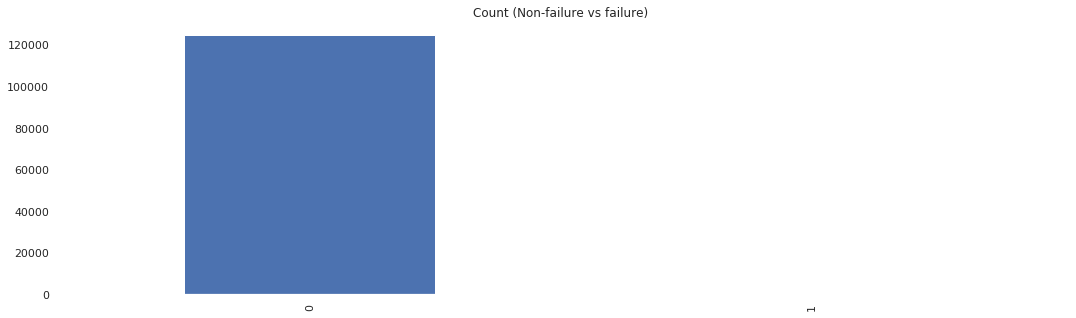

In [1008]:
plt.rcParams['figure.figsize'] = (18.0, 5.0)
dataset.failure.value_counts().plot(kind='bar', title='Count (Non-failure vs failure)')

There are 106 samples, approaximately 0.0852%, indicating failure. The above distribution shows that the dataset is perfectly imbalanced. In order to grasp the overall representation of the dataset, it is favorable to look into the characteristics of each variable, first. A scatter plot will used to get a overall picture of variables and then further steps will get down to more specifics with values of each variable in the following sections. The following lines will first reveal the number of unique values in each variable and will give an overall idea of how each variable contributes to failure and non-failure.

In [1724]:
# Show distinct values of each variable.
columns = dataset.columns
no_unique_values = []
for column in columns:
    unique_values = np.unique(dataset[column])
    print('{}: {} distinct values -  {}'.format(column, len(unique_values), unique_values))
    no_unique_values.append(len(unique_values))

date: 304 distinct values -  ['2015-01-01T00:00:00.000000000' '2015-01-02T00:00:00.000000000'
 '2015-01-03T00:00:00.000000000' '2015-01-04T00:00:00.000000000'
 '2015-01-05T00:00:00.000000000' '2015-01-06T00:00:00.000000000'
 '2015-01-07T00:00:00.000000000' '2015-01-08T00:00:00.000000000'
 '2015-01-09T00:00:00.000000000' '2015-01-10T00:00:00.000000000'
 '2015-01-11T00:00:00.000000000' '2015-01-12T00:00:00.000000000'
 '2015-01-13T00:00:00.000000000' '2015-01-14T00:00:00.000000000'
 '2015-01-15T00:00:00.000000000' '2015-01-16T00:00:00.000000000'
 '2015-01-17T00:00:00.000000000' '2015-01-18T00:00:00.000000000'
 '2015-01-19T00:00:00.000000000' '2015-01-20T00:00:00.000000000'
 '2015-01-21T00:00:00.000000000' '2015-01-22T00:00:00.000000000'
 '2015-01-23T00:00:00.000000000' '2015-01-24T00:00:00.000000000'
 '2015-01-25T00:00:00.000000000' '2015-01-26T00:00:00.000000000'
 '2015-01-27T00:00:00.000000000' '2015-01-28T00:00:00.000000000'
 '2015-01-29T00:00:00.000000000' '2015-01-30T00:00:00.0000000

'attribute1' and 'attribute6' have relatively high numbers of unique values while numbers of unique values for other values are small. Those two variables must have a lot of ways for the predictive model to learn non-failures of devices. The predictive model must not only know how to tell devices with failure but it also has to learn ways to failure, too. A brief summary will help grasp the picture of the dataset.

No. of unique vaues for each variable

- date : 304 unique values.
- devce: 1,169 unique values.
- attribute1: 123,877 unique values.
- attribute2: 558 unique values.
- attribute3: 47 unique values.
- attribute4: 115 unique values.
- attribute5: 60 unique values.
- attribute6: 44,838 unique values.
- attribute7: 28 unique values.
- attribute9: 65 unique values.

Values of 'attribute1' and 'attribute6' are much higher and the ranges of those values are much broader than the ranges of values of other variables. Values of 'attribute7' seem to be incrementing, kind of, irregularly but a common regular pattern can be found if the numbers of 'attribute7' are multiples of the number of 2. Values of 'attribute1' and 'attribute2' could be multiples of 'attribute7' since all the values in those variables can be divided by 2. Hence, 'attribute1', 'attribute2', and 'attribute7', might have strong correlations among them. 

attribute7' and 'attribute8' seem to be idential to one another. Either of the variables, 'attribute7' or 'attribute8', should be removed from analysis if those variables are used by Logistic Regression or Ordinal Regression since those analyses stronly assume little or no multicollinearity. 

'attribute1' is multiples of 'attribute2', either of those two variables should also be remove from the dataset unless only one of them shoudl be used. Otherwise, they will cause a multicollinearity problem if Logistic Regression or Ordinal Regression analyses are implemented for the predictive model. 'attribute1' seems to express the daily amount of data handled by each device. Although Logistics Regression and Ordinary Regression are not applied here, but those multi-collinearity issues should be noted.

Let's first check if 'attribute7' and 'attribute8' are identical to one another.

In [408]:
# Create two different dataframes for attribute7 and attribute8.
attribute_7 = pd.DataFrame(dataset, columns = ['attribute7'])
attribute_8 = pd.DataFrame(dataset, columns = ['attribute8'])

# Compare attribute7 and attribute8 by their values for each record.
attribute_test['matched'] = pd.DataFrame(np.where(attribute_7.attribute7 == attribute_8.attribute8, 'True', 'False'))

In [409]:
# See the number of matched values.
attribute_test.matched.value_counts()

True    124494
Name: matched, dtype: int64

It is safe to say 'attribute7' is a duplicate of 'attribute8' or the other way around. As mentioned earlier above, if a variable is a copy of another variable, it could be problematic when the predictive model is developed using Logistic Regression Classifier since Logistic Regression assumes little or no multi-collinearity among independent variables, so either of them should be removed from the dataset or they both can stay in the dataset as long as only one of them is applied to the model development. 

If the model is developed by using a ensemble classfier such as Random Forest, the effect of multi-collinearity would not have much impact on the preditive model since Random Forest will create the predictive model with random selection of features at each node creation, but in general the effect is not removed completely. It could be experimented during the model development.

It would be useful if the overall number of unique values in each variable could be presented with graphical representations. A pie chart and a bar chart would do the trick to understand the overall characteristics of distributions of unique values in the dataset.

In [1731]:
'''
    It returns an array of numbers of unique values in each variable.
'''
def get_no_unique_values(columns):
    no_unique_values = []
    for column in columns:
        no_unique_value = dataset[column].nunique()
        no_unique_values.append(no_unique_value)
    return no_unique_values

'''
    Plot a bar chart for the number of unique values in each variable.
    Numbers of unique values of each variable will also be displayed on top of each bar,
    otherwise those small values would have no way to display themselves.
'''
def plot_no_unique_values_bar_chart(columns):
    no_unique_values = get_no_unique_values(columns)
    total_no_unique_value = sum(no_unique_values)
    percentages = []
    
    for value in no_unique_values:
        percentages.append(round((value/total_no_unique_value)*100, 4))
        
    fig, ax = plt.subplots()
    percent_idx = 0
    for i, v in enumerate(no_unique_values):
        ax.text(v + 3, i + .25, str(v)+str("  (")+str(percentages[percent_idx])+str("%)"), color='green')
        percent_idx += 1

    width = 0.65 # the width of the bars 
    ind = np.arange(len(no_unique_values)) 
    ax.barh(ind, no_unique_values, width, color="blue")
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(columns, minor=False)
    plt.title('No. of unique values by variable')
    plt.xlabel('No. of unique values')
    plt.ylabel('Variables') 
    plt.show()

'''
    It will plot a pie chart for number of unique values of each variable.
    The pie chart will be appropriate to quickly grasp what takes dominating numbers of unique values.
'''
def plot_no_unique_values_pie_chart(columns):
    no_unique_values = get_no_unique_values(columns)
    plt.pie(no_unique_values, labels=columns,  autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')
    plt.show()


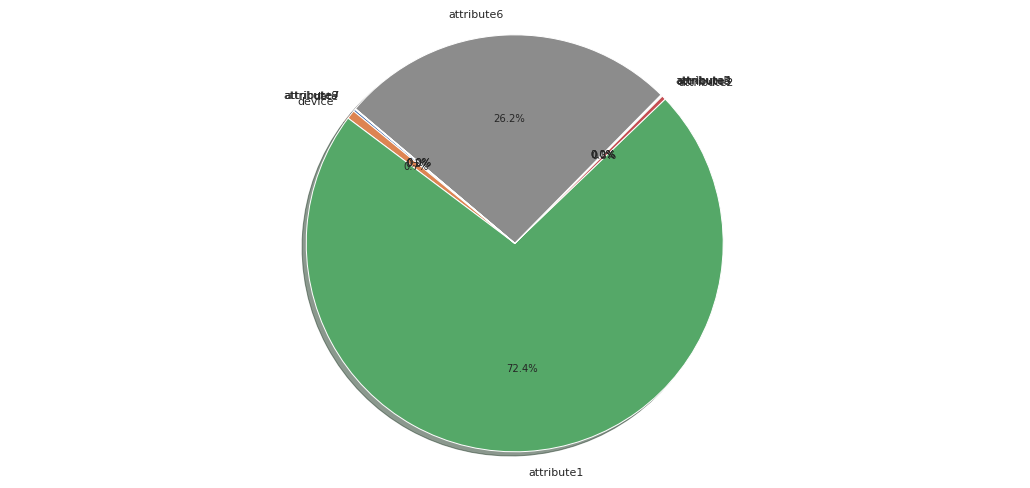

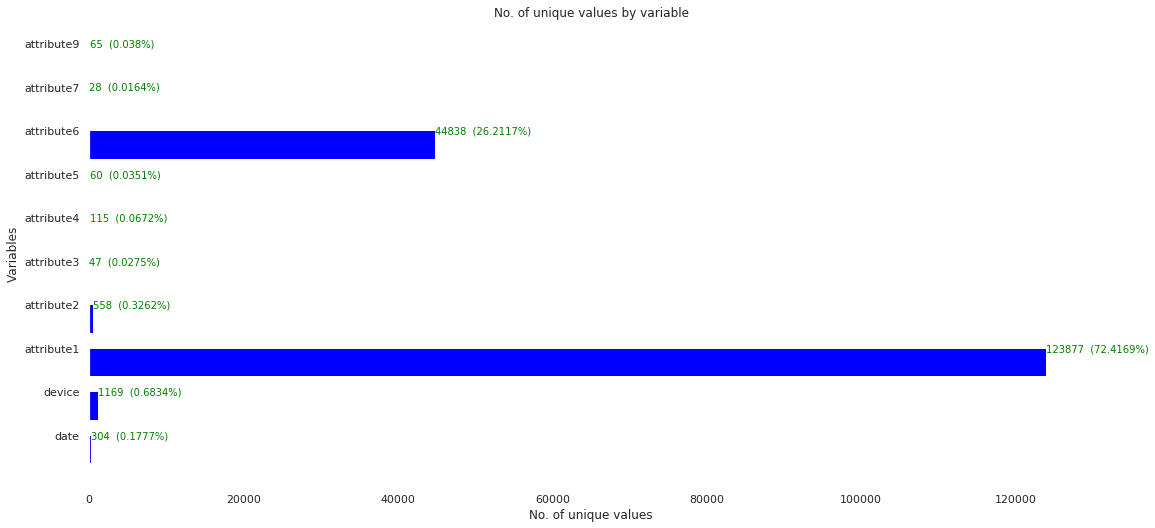

In [1009]:
'''
    attribute8 is removed from the column list since it is a duplicate of attribute7.
'''
columns = ['date',       'device',     'attribute1',
           'attribute2', 'attribute3', 'attribute4', 
           'attribute5', 'attribute6', 'attribute7', 
           'attribute9'] 

'''
    Generate a pie chart to quickly understand the overall information.
'''
plt.rcParams['figure.figsize'] = (18.0, 8.5)
plot_no_unique_values_pie_chart(columns)


'''
    Generate a bar chart for more details with counts of unique values in each variable. 
'''
plt.rcParams['figure.figsize'] = (18.0, 8.5)
plot_no_unique_values_bar_chart(columns)

It is clear to see that 'attribute1' and 'attribute6' have dominating numbers of unique values while other values have relatively small numbers of unique values. Values of 'attribute1' are assumed to be some daily data exchange amount and 'attribute6' seems to have a close relationship with 'attribute1' sharing a common characteristic that values of those two variables can be divided by 8.

The dataset has many dimensions, features, and Principal Component Analysis is applied to reduce the dimentions of variables in the dataset to see the overall degree of spread of contributions to failure and non-failure. 

In [1]:
def plot_pca_2d_space(X, label='Imbalanced dataset (2 PCA components)'):   
    pca = PCA(n_components=2)
    X = pca.fit_transform(X)
    Y = dataset.failure
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(Y), colors, markers):
        plt.scatter(
            X[Y==l, 0],
            X[Y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()
    


Although it is not really intuitive to understand what it really means, PCA still can be used to summarize the degree of contributions to failure and non-failure of variables. The PCA scatter tells that values contributing to failure are positioned at relatively lower coordinates. If PCA is applied to a less number of variables with similar characteristics, the PCA scatter plot will be effective to summarize the spread or clusters of failure and non-failure contributions. PCA will be used whenever necessary during modeling processes.

Next, unique values, contributing to failure, in each variable will be studied. The following uitility functions will plot the distribution of contributions of unique values in each variable.  

In [1415]:
total_record = dataset['failure'].count() # Get a count of total records of the dataset.
failure_summary_table = [["Variable", "Total", "Failure", "Non-failure", "Intersected"]] # Prepare a summary table.

'''
    This will plot statistics on unique values with failure contribution.
'''
def plot_unique_value_failure_contribution_by_variable(attr):
    
    '''
        Prepare dataframe from the original dataset for required statistics.
    '''
    plt.rcParams['figure.figsize'] = (18.0, 3.5)
    attr_failure_info = dataset['failure'] == 1
    df1 = pd.DataFrame(dataset, columns=[attr])
    df2 = pd.DataFrame(dataset[attr_failure_info], columns=[attr])
    attr_failure_info = dataset[attr_failure_info].groupby(attr).failure.sum()
    attr_failure_info.plot(kind='bar', color='red', title='No. of failures by values of ' + str(attr))        
    
    '''
        Compute necessary information to generate summary statistics on unique values with 
        contributions to failure and non-failure.
    '''
    total_no_uniq_values = dataset[attr].nunique()
    unique_value_ratio = round((total_no_uniq_values/total_record)*100, 4)
    failures = attr_failure_info.count()
    failure_ratio = round((failures/total_no_uniq_values)*100, 4)
    non_failures = total_no_uniq_values - failures
    non_failure_ratio = round((non_failures/total_no_uniq_values)*100, 4)
    intersection_df = pd.merge(df1, df2, on=[attr], how='inner')
    intersection = intersection_df[attr].nunique()
    intersection_ratio = round((intersection/failures)*100, 4)
    
    '''
        Store summaries on unique values with failure contribution.
    '''
    tr = ['{}'.format(attr), 
          '{:,}({:.2f}%)'.format(total_no_uniq_values, unique_value_ratio),
          '{:,}({:.2f}%)'.format(failures, failure_ratio),
          '{:,}({:.2f}%)'.format(non_failures, non_failure_ratio),
          '{:,}({:.2f}%)'.format(intersection, intersection_ratio)
         ]
    failure_summary_table.append(tr)
    
    '''
        Print statistics on unique values with failure and non-failure contributions
    '''
    print()
    print(str("---") + attr + str("---"))
    print('Total unique values: {:,} ({:.2f}%)'.format(total_no_uniq_values, unique_value_ratio))
    print('failures: {:,} ({:.2f}%)'.format(failures, failure_ratio))
    print('non-failures: {:,} ({:.2f}%)'.format(non_failures, non_failure_ratio))    
    print('intersected: {:,} ({:.2f}%)'.format(intersection, intersection_ratio))
    
    '''
        Show summaries and the chart with information on failure contribution.
    '''
    plt.show()


---attribute1---
Total unique values: 123,877 (99.50%)
failures: 106 (0.09%)
non-failures: 123,771 (99.91%)
intersected: 106 (100.00%)


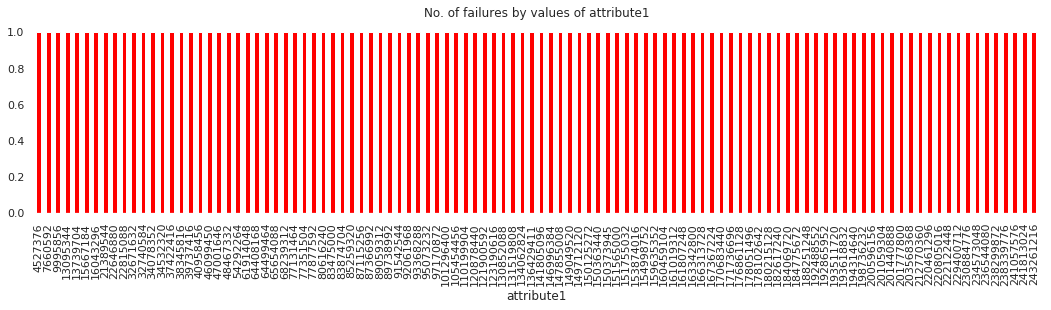

In [1416]:
# See how unique values in attribute1 contributes to failure. 
plot_unique_value_failure_contribution_by_variable('attribute1')

There are 106 unique values contributing to failure and 123,777 unique values contributing to non-failure in 'attribute1, less than 1% of the total number of unique values in 'attribute1', contributes to failure. It should be noted that the same number of unique values contributing to failure also contributes to non-failure, that's what the intersection ratio of 100% says. Each of 106 unique values has an equal chance of contributing to failure, only once for each. 


---attribute2---
Total unique values: 558 (0.45%)
failures: 48 (8.60%)
non-failures: 510 (91.40%)
intersected: 48 (100.00%)


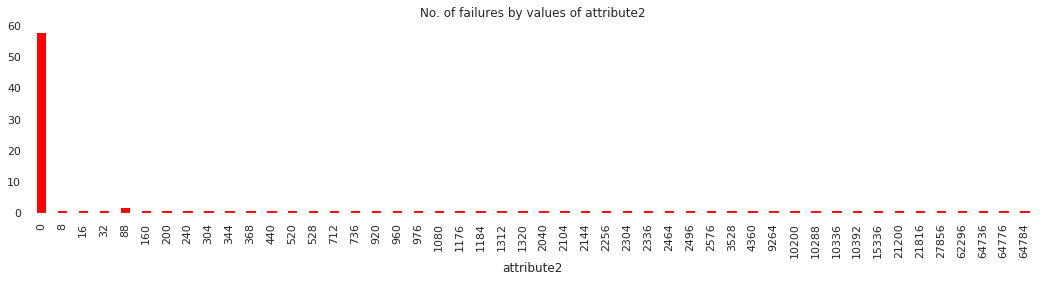

In [1417]:
# See how unique values in attribute2 contribute to failure. 
plot_unique_value_failure_contribution_by_variable('attribute2')

There are 48 unique values contributing to failure and 510 unique values contributing to non-failure in 'attribute2, 8.60% of the total number of unique values in 'attribute1', contributes to failure. The intersection ratio of 100% says that 'attribute2' also has the same number of unique values contributing both failure and non-failure as 'attribute1'. The unique value of 0 has the most contributions to failure while other unique values has almost the same chance to contribute to failure.


---attribute3---
Total unique values: 47 (0.04%)
failures: 7 (14.89%)
non-failures: 40 (85.11%)
intersected: 7 (100.00%)


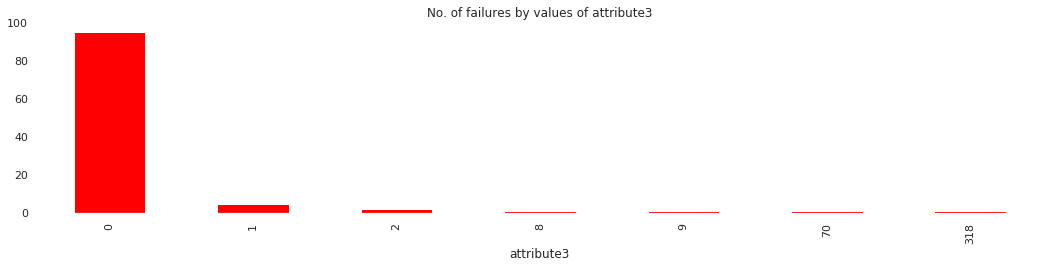

In [1418]:
# See how unique values in attribute3 contribute to failure. 
plot_unique_value_failure_contribution_by_variable('attribute3')

There are only 7 unique values contributing to failure and 40 unique values contributing to non-failure in 'attribute3'. 14.89% of the total number of unique values in 'attribute3', contributes to failure. The intersection ratio of 100% says that all of the unique values contributing to failure also contribute to non-failure. The most contributions to failure concentrate on the unique value of 0 while other unique values merely contribute to failure. It shows a similar failure contribution pattern to 'attribute2'.


---attribute4---
Total unique values: 115 (0.09%)
failures: 40 (34.78%)
non-failures: 75 (65.22%)
intersected: 40 (100.00%)


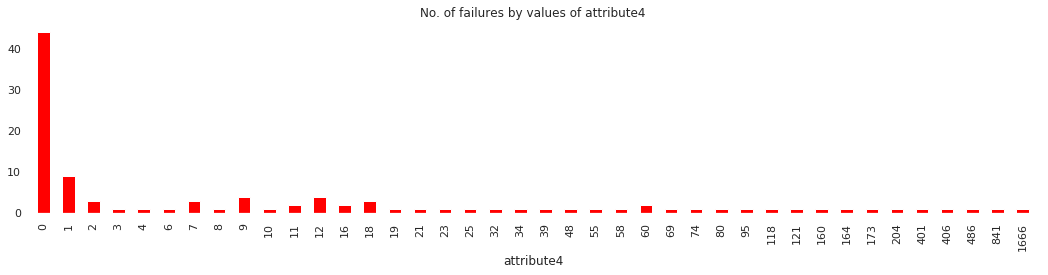

In [1419]:
# See how unique values in attribute4 contribute to failure. 
plot_unique_value_failure_contribution_by_variable('attribute4')

There are 40 unique values contributing to failure while 75 unique values contribute to non-failure in 'attribute4'. 34.78% of the total number of unique values in 'attribute4', contributes to failure. The intersection ratio of 100% says that all of the unique values contributing to failure also contribute to non-failure. 'attribute4' shows kind of a similar pattern to 'attribute2' and 'attribute3' but 'attribute4' has more ways than 'attribute3' but less ways than 'attribute2' to contribute to failure. It should be noted that 'attribute4' has the most contributions on the value of 0, it is a similar pattern to 'attribute2' and 'attribute3'. 


---attribute5---
Total unique values: 60 (0.05%)
failures: 28 (46.67%)
non-failures: 32 (53.33%)
intersected: 28 (100.00%)


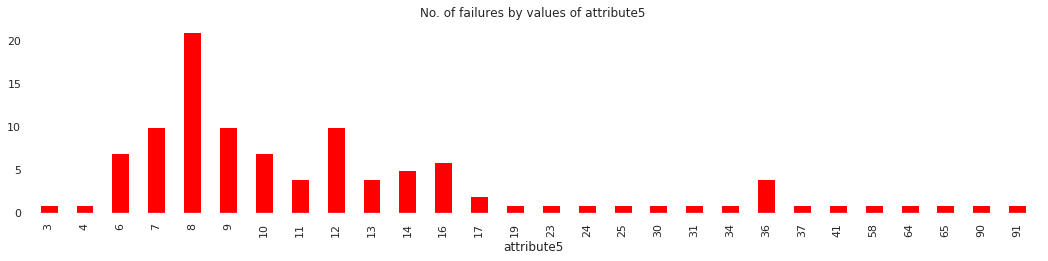

In [1421]:
# See how unique values in attribute5 contribute to failure. 
plot_unique_value_failure_contribution_by_variable('attribute5')

There are 28 unique values contributing to failure while 32 unique values contribute to non-failure in 'attribute4'. 46.37% of the total number of unique values in 'attribute5', contributes to failure. The intersection ratio of 100% says that all of the unique values contributing to failure also contribute to non-failure. Unlike 'attribute1', 'attribute2', 'attribute3', and 'attribute4', it shows kind of unique ways to contributing to failure. The intersection ratio says that 28 unique values contributing to failure also contribute to non-failure.


---attribute6---
Total unique values: 44,838 (36.02%)
failures: 105 (0.23%)
non-failures: 44,733 (99.77%)
intersected: 105 (100.00%)


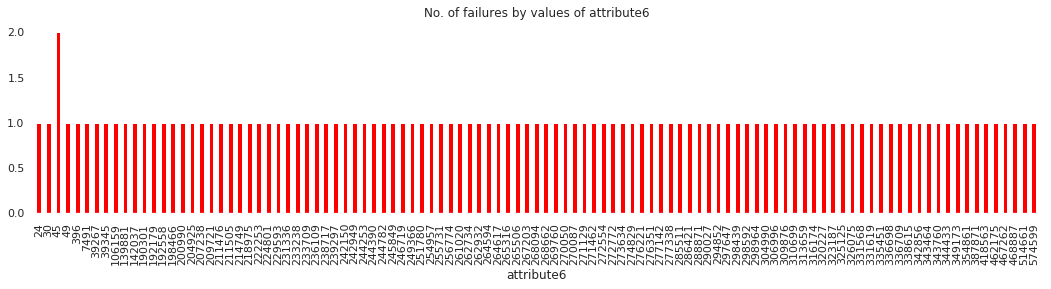

In [1422]:
# See how unique values in attribute6 contribute to failure. 
plot_unique_value_failure_contribution_by_variable('attribute6')

There are 44,733 unique values contribute to non-failure while only 105 unique values of 'attribute6' contribute to failure. The intersection ratio is 100%. It shows kind of almost the same pattern of contributing to failure as 'attribute1'. Somehow, it seems that 'attribute1' is a duplicate of 'attribute6' with multiples of values in 'attribute6'. Moreover, the number of unique values contributing to failure is equal to the number of unique values in 'attribute1'. Although the number of unique values contributing to failure and the total number of contributions of unique values in 'attribute6' are the same as 'attribute1', it should be noted that 'attribute1' has more way to contributing failure than 'attribute1' has.


---attribute7---
Total unique values: 28 (0.02%)
failures: 16 (57.14%)
non-failures: 12 (42.86%)
intersected: 16 (100.00%)


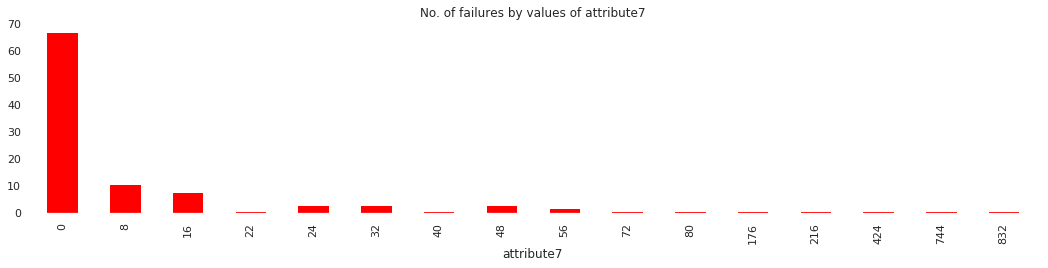

In [1423]:
# See how unique values in attribute7 contribute to failure. 
plot_unique_value_failure_contribution_by_variable('attribute7')

There are only 16 unique values contribute to non-failure while only 12 unique values of 'attribute7' contribute to failure. The total number of unique values is very small compared to the number of unique values of other variables. The intersection ratio is 100%. The shape of contributions to failure is, somehow, similar to 'attribute3'. However, if the number of unique values is compared, 'attribute7' has less unique values than 'attribute3' but it has more unique values partipating in contributing to failure than 'attribute3' does.


---attribute9---
Total unique values: 65 (0.05%)
failures: 14 (21.54%)
non-failures: 51 (78.46%)
intersected: 14 (100.00%)


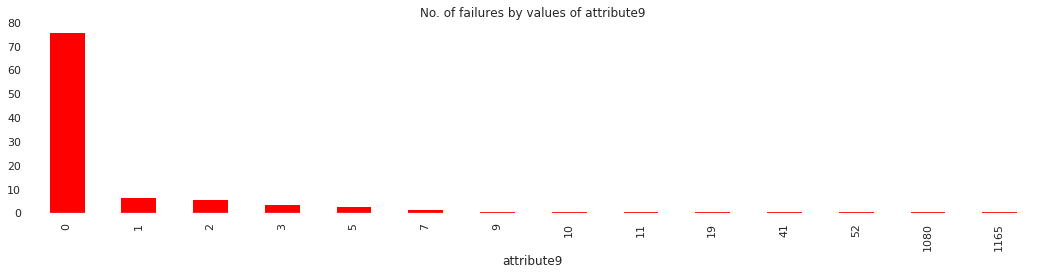

In [1424]:
# See how unique values in attribute3 contribute to failure. 
plot_unique_value_failure_contribution_by_variable('attribute9')

'attribute2, 'attribute3, 'attribute4', 'attribute7', and 'attribute9' have similar patterns in terms of the unique value that gets the most contributions to failure. There are only 14 unique values that contribute to failure while 52 unique values of 'attribute9' contribute to non-failure. The intersected ratio is 100%. 

So far, unique valures contributing to failure have been studied. Let's also take a look at unique values contributing to non-failure. A utility function for generating histograms should be defined.

In [1032]:
'''
    Show a box plot for value ranages.
    The box plot will assist the histogram in showing small values of non-failure contributions 
    of unique values.
'''    
def plot_horizontal_unique_value_contribution_box_plot_by_variable(column):
    ax.boxplot(dataset[column], False, sym='rs', vert=False, whis=0.5, positions=[0], widths=[0.4])
    plt.tight_layout()
    plt.show()

'''
    Show a histogram for variable.
    The histogram will give an overview of non-failure contributions of unique values.
'''
def plot_unique_value_non_failure_contribution_by_variable(column, bins):    
    attr_failure_info = dataset['failure'] == 0
    attr_failure_info = dataset[attr_failure_info]
    plt.hist(attr_failure_info[column], bins, facecolor='red')
    plt.show()

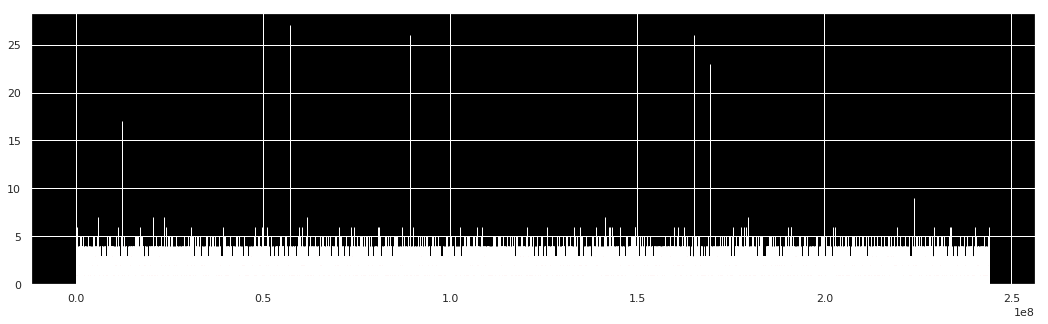

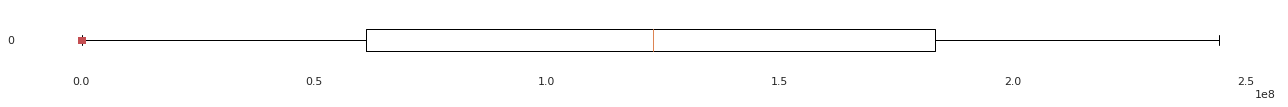

In [1034]:
# See how unique values in attribute1 contribute to non-failure.
plt.rcParams['figure.figsize'] = (18.0, 5.0) # Plot a hostogram.
plt.rcParams['axes.facecolor'] = 'black'
plot_unique_value_non_failure_contribution_by_variable('attribute1', 130000)

plt.rcParams['figure.figsize'] = (18.0, 2.5) # Plot a box plot.
plt.rcParams['axes.facecolor'] = 'white'
plot_horizontal_unique_value_contribution_box_plot_by_variable('attribute1')


---attribute1---
Total unique values: 123,877 (99.50%)
failures: 106 (0.09%)
non-failures: 123,771 (99.91%)
intersected: 106 (100.00%)


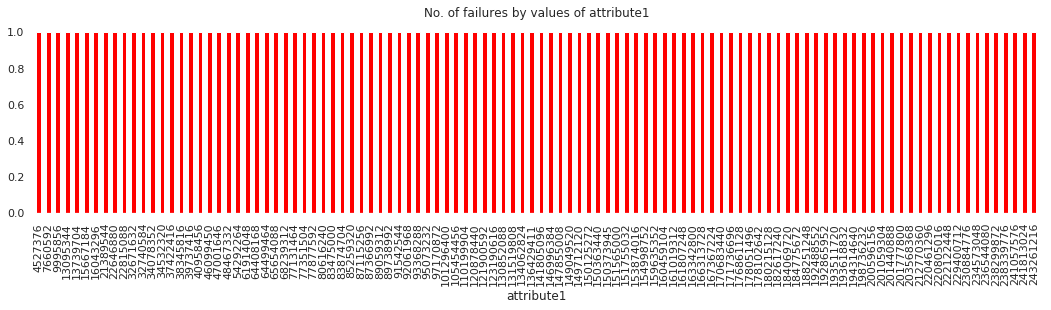

In [1187]:
plt.rcParams['axes.facecolor'] = 'white'
plot_unique_value_failure_contribution_by_variable('attribute1')

In [1041]:
max_count_test = dataset.failure == 0
max_count_test = dataset[max_count_test].groupby('attribute1').failure.count().max()
print(max_count_test)

26


The maximum contribution of 'attribute1' is 26. There are 123,877 unique values in 'attribute1' and the number of records in the dataset are 124,494. It is approximately 

$$ \frac{123877}{124494} \times 100 = 99.5 \% $$

Most of the unique values will only contribute once to non-failure while merely few of them contribute to non-failure more than once. It basically tells that 'atrribute1' knows a wide variety of options to get to non-failure while there are only few ways to contribute to failure. 

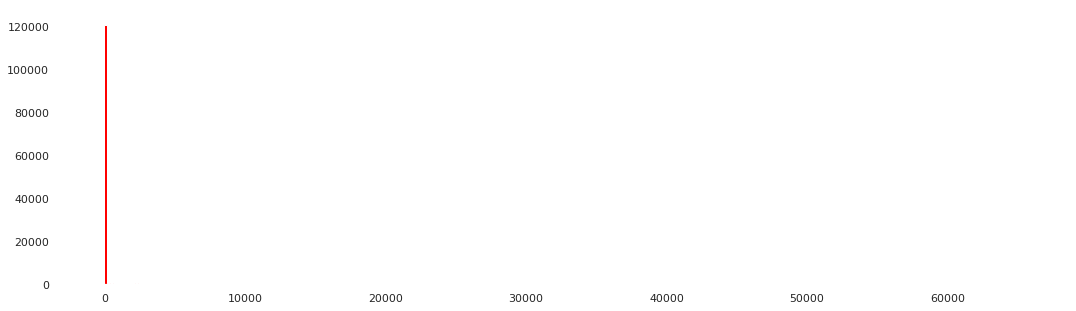

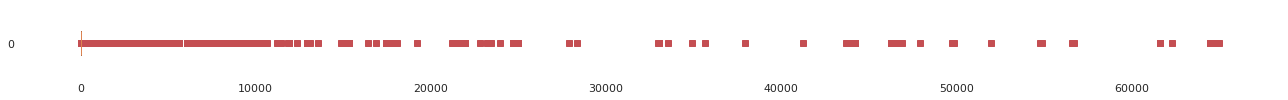

In [1006]:
# See how unique values in attribute2 contribute to non-failure.
plt.rcParams['axes.facecolor'] = 'white'

plt.rcParams['figure.figsize'] = (18.0, 5.0)
plot_unique_value_non_failure_contribution_by_variable('attribute2', 300)

plt.rcParams['figure.figsize'] = (18.0, 2.5)
plot_horizontal_unique_value_contribution_box_plot_by_variable('attribute2')


---attribute2---
Total unique values: 558 (0.45%)
failures: 48 (8.60%)
non-failures: 510 (91.40%)
intersected: 48 (100.00%)


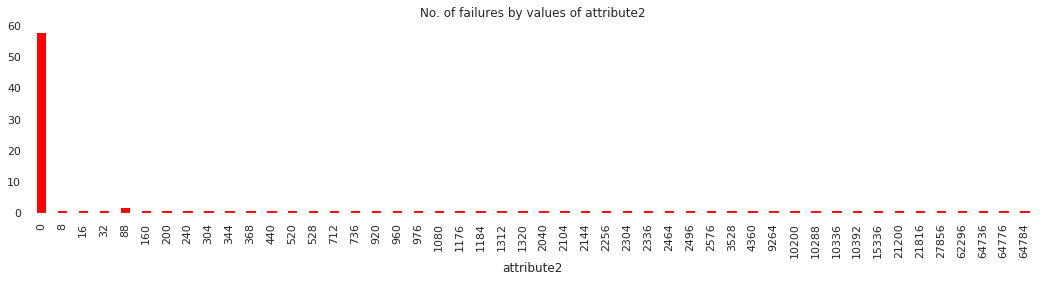

In [1186]:
plt.rcParams['axes.facecolor'] = 'white'
plot_unique_value_failure_contribution_by_variable('attribute2')

Although other unique values of 'attribute2' contribute to non-failure, most of contributions to non-failure are done by the unique value of 0. 'attribute2' also shows almost the same pattern as in the case with the failure contribution case above.

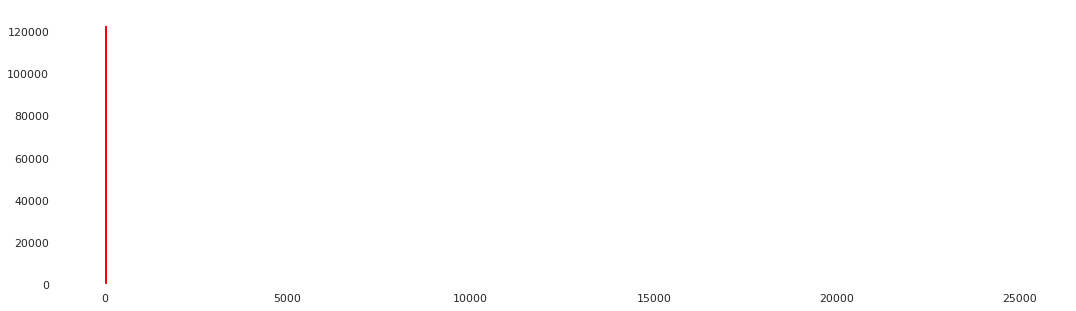

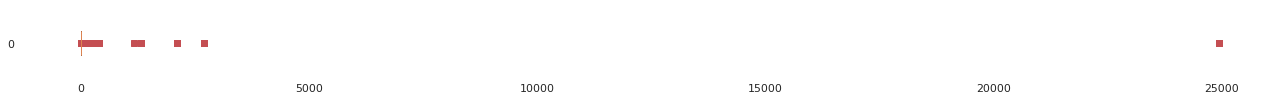

In [1054]:
# See how unique values in attribute3 contribute to non-failure.
plt.rcParams['figure.figsize'] = (18.0, 5.0)
plot_unique_value_non_failure_contribution_by_variable('attribute3', 300)

plt.rcParams['figure.figsize'] = (18.0, 2.5)
plot_horizontal_unique_value_contribution_box_plot_by_variable('attribute3')

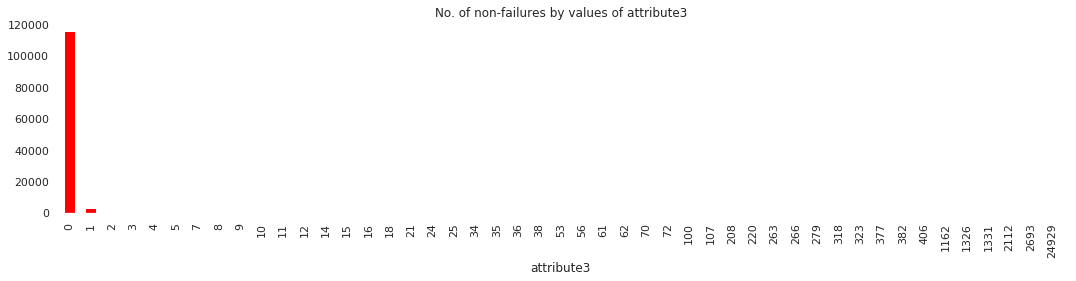

In [1182]:
plt.rcParams['figure.figsize'] = (18.0, 3.5)
attr_failure_info = dataset['failure'] == 0
attr_failure_info = dataset[attr_failure_info].groupby('attribute3').failure.count()
attr_failure_info.plot(kind='bar', color='red', title='No. of non-failures by values of ' + str('attribute3'))          
plt.show()

'attribute3' shows some unique values contributing to non-failure. However, most of the contributions to non-failure are done by the unique values of 0. Although the range of unique values of 'attribute3' is wide, there are not many unique values compared to the range.

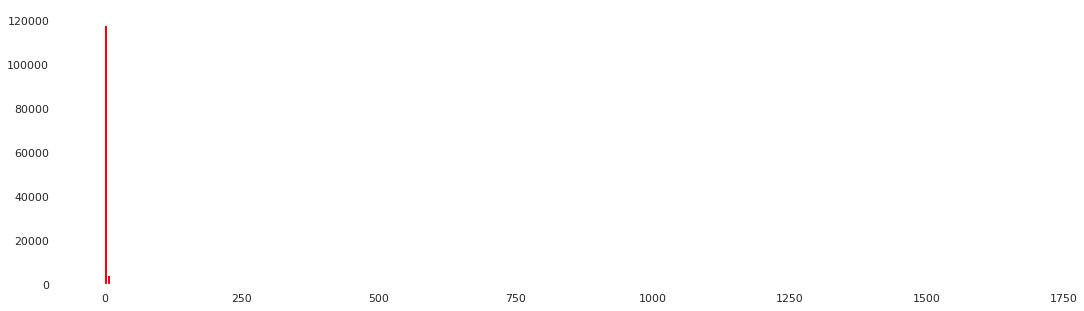

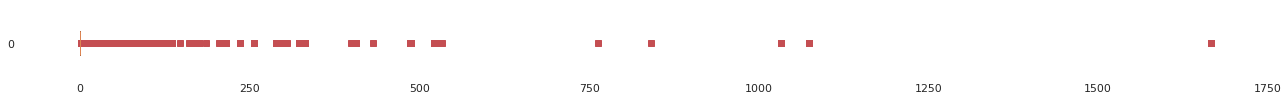

In [1053]:
# See how unique values in attribute3 contribute to non-failure.
plt.rcParams['figure.figsize'] = (18.0, 5.0)
plot_unique_value_non_failure_contribution_by_variable('attribute4', 300)

plt.rcParams['figure.figsize'] = (18.0, 2.5)
plot_horizontal_unique_value_contribution_box_plot_by_variable('attribute4')

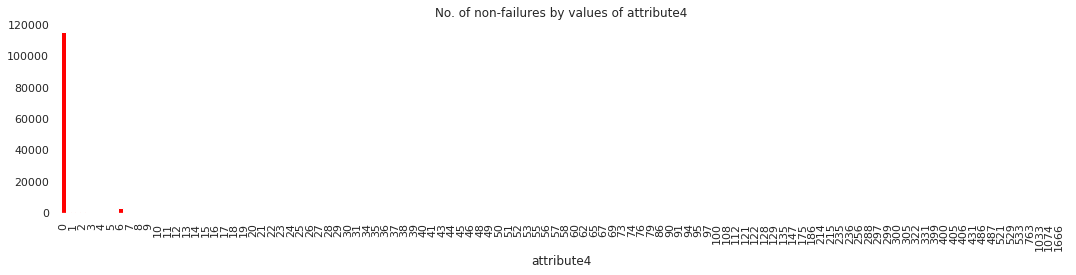

In [1181]:
plt.rcParams['figure.figsize'] = (18.0, 3.5)
attr_failure_info = dataset['failure'] == 0
attr_failure_info = dataset[attr_failure_info].groupby('attribute4').failure.count()
attr_failure_info.plot(kind='bar', color='red', title='No. of non-failures by values of ' + str('attribute4'))          
plt.show()

'attribute4' also shows a similar pattern to 'attribute2' and 'attribute3'. Most of the contributions to non-failure are done by the unique value of 0.

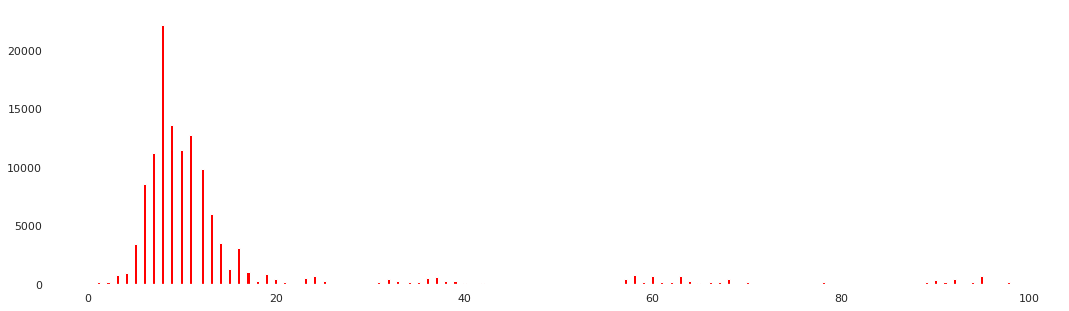

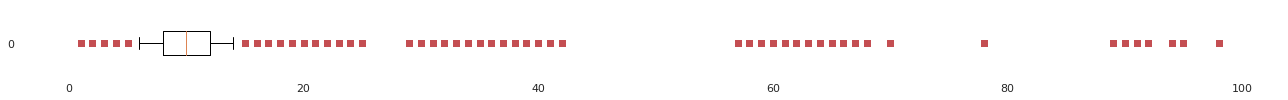

In [1055]:
# See how unique values in attribute3 contribute to non-failure.
plt.rcParams['figure.figsize'] = (18.0, 5.0)
plot_unique_value_non_failure_contribution_by_variable('attribute5', 300)

plt.rcParams['figure.figsize'] = (18.0, 2.5)
plot_horizontal_unique_value_contribution_box_plot_by_variable('attribute5')

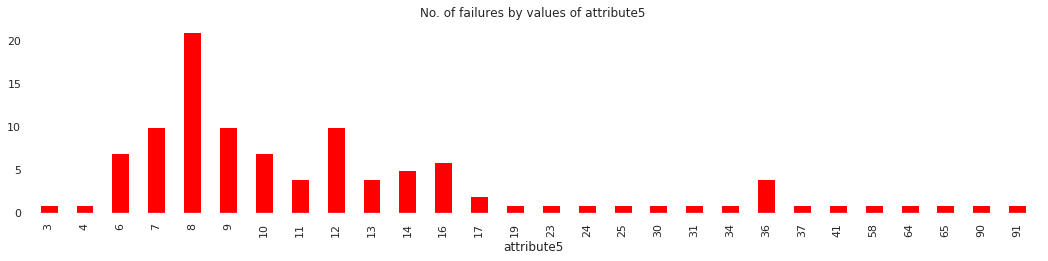

In [1066]:
attr_failure_info = dataset['failure'] == 1
attr_failure_info = dataset[attr_failure_info].groupby('attribute5').failure.sum()
attr_failure_info.plot(kind='bar', color='red', title='No. of failures by values of ' + str('attribute5'))          
plt.show()

'attribute5' shows uniquely different patterns from patterns of unique values of other variables but it shows almost the same pattern as in the case with contributions to failure. The two contribution shapes are compared above. The behaviours of non-failure contributions of unique values in 'attribute5' almost identical to the case in which unique values contribute to failure.

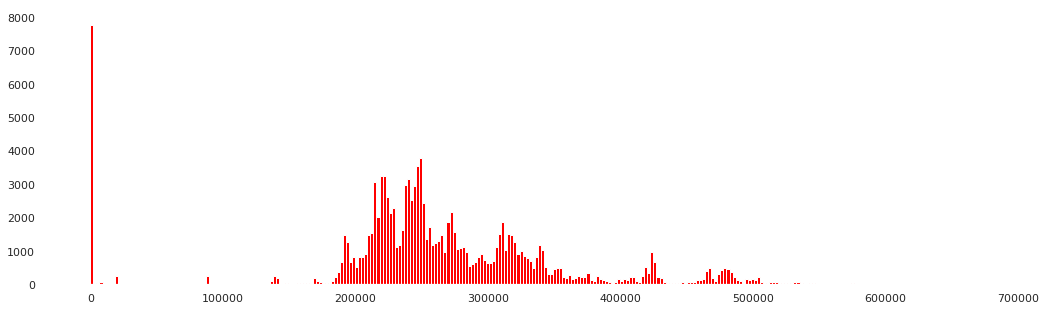

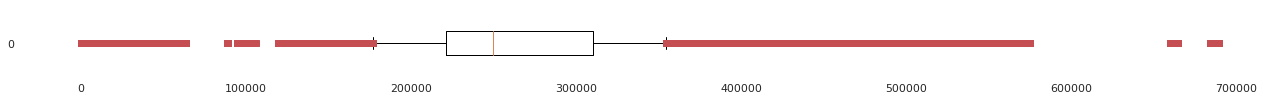

In [1081]:
# See how unique values in attribute3 contribute to non-failure.
plt.rcParams['figure.figsize'] = (18.0, 5.0)
plot_unique_value_non_failure_contribution_by_variable('attribute6', 300)

plt.rcParams['figure.figsize'] = (18.0, 2.5)
plot_horizontal_unique_value_contribution_box_plot_by_variable('attribute6')

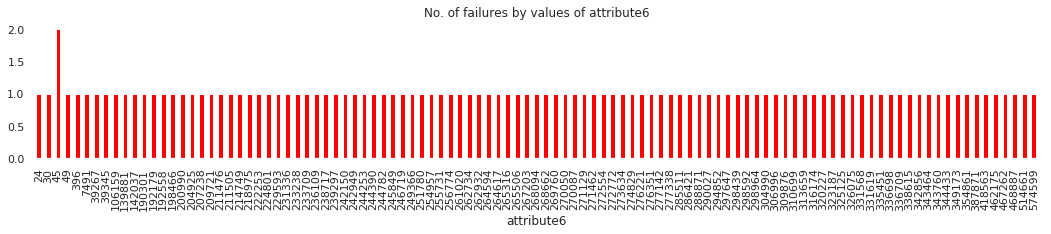

In [1068]:
attr_failure_info = dataset['failure'] == 1
attr_failure_info = dataset[attr_failure_info].groupby('attribute6').failure.sum()
attr_failure_info.plot(kind='bar', color='red', title='No. of failures by values of ' + str('attribute6'))          
plt.show()

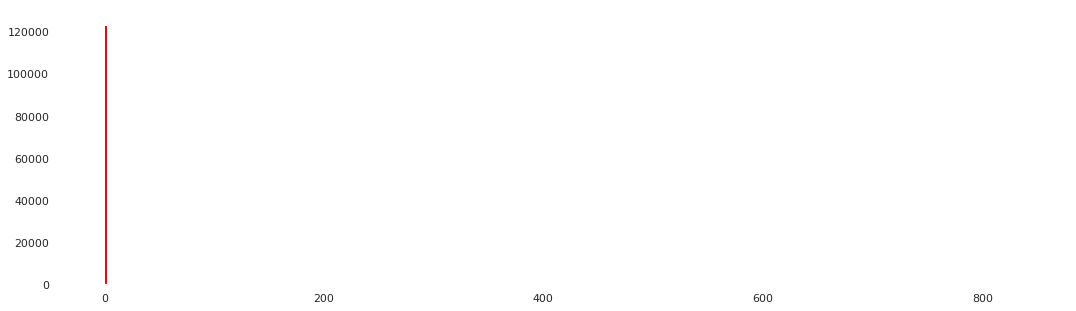

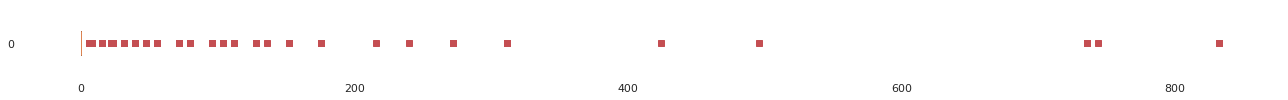

In [1076]:
# See how unique values in attribute3 contribute to non-failure.
plt.rcParams['figure.figsize'] = (18.0, 5.0)
plot_unique_value_non_failure_contribution_by_variable('attribute7', 300)

plt.rcParams['figure.figsize'] = (18.0, 2.5)
plot_horizontal_unique_value_contribution_box_plot_by_variable('attribute7')

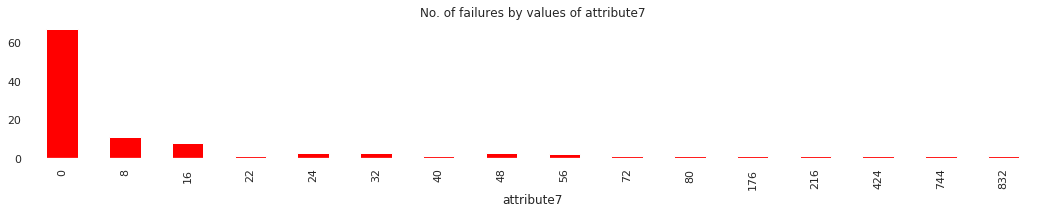

In [1077]:
attr_failure_info = dataset['failure'] == 1
attr_failure_info = dataset[attr_failure_info].groupby('attribute7').failure.sum()
attr_failure_info.plot(kind='bar', color='red', title='No. of failures by values of ' + str('attribute7'))          
plt.show()

'attribute7' shows almost identical contribution patterns between unique values contributing to non-failure and unique values contributing to failure.

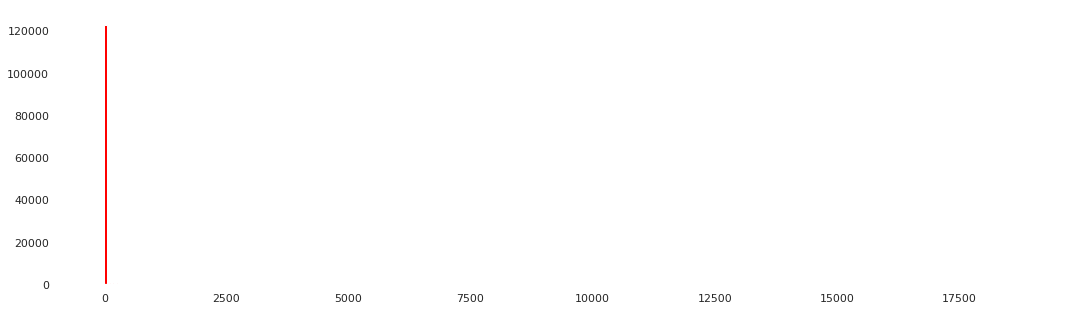

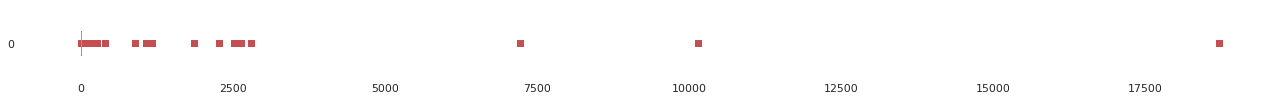

In [1079]:
# See how unique values in attribute3 contribute to non-failure.
plt.rcParams['figure.figsize'] = (18.0, 5.0)
plot_unique_value_non_failure_contribution_by_variable('attribute9', 300)

plt.rcParams['figure.figsize'] = (18.0, 2.5)
plot_horizontal_unique_value_contribution_box_plot_by_variable('attribute9')

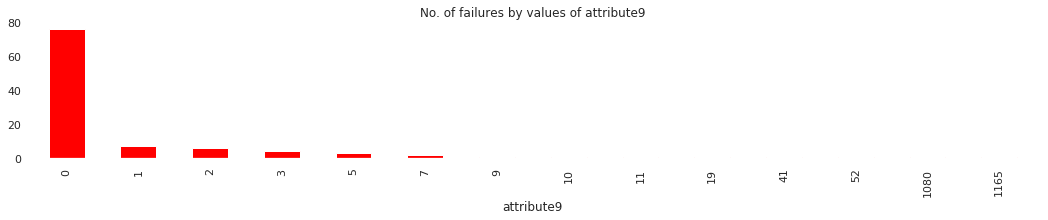

In [1080]:
attr_failure_info = dataset['failure'] == 1
attr_failure_info = dataset[attr_failure_info].groupby('attribute9').failure.sum()
attr_failure_info.plot(kind='bar', color='red', title='No. of failures by values of ' + str('attribute9'))          
plt.show()

'attribute9' also shows almost identical contribution patterns between unique values contributing to non-failure and unique values contributing to failure.

Having studied variables in the dataset, some variables could be assumed to play better for detecting devices with failure. However, the predictive model has to know how to detecting failure and non-failure at the same time. Keeping that in mind, as many different senarios will be tried out to see how the predictive model would perform on variables with or without sampling techniques. Before preceding further, applying PCA might be good to understand the characteristics of variables. PCA is applied to variables of 'attribute2', 'attribute3', 'attribute4', 'attribute7', and 'attribute9'. 

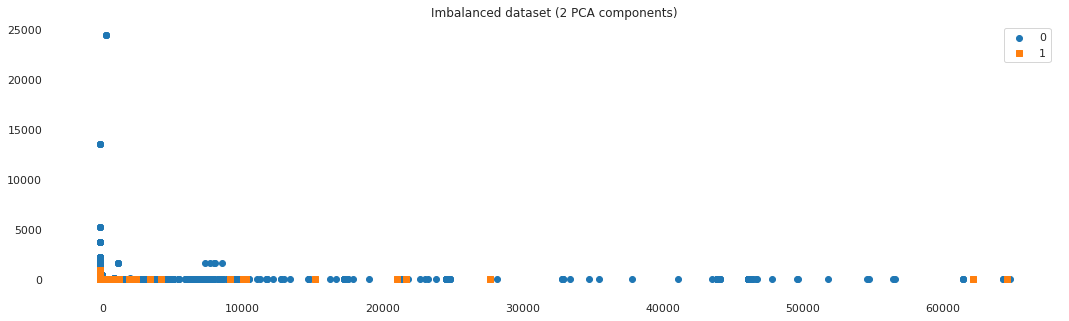

In [1744]:
X = dataset[['attribute2', 'attribute3', 'attribute4', 'attribute7', 'attribute9']]
plot_pca_2d_space(X)

If PCA is only applied to 'attribute2' and 'attribute3'

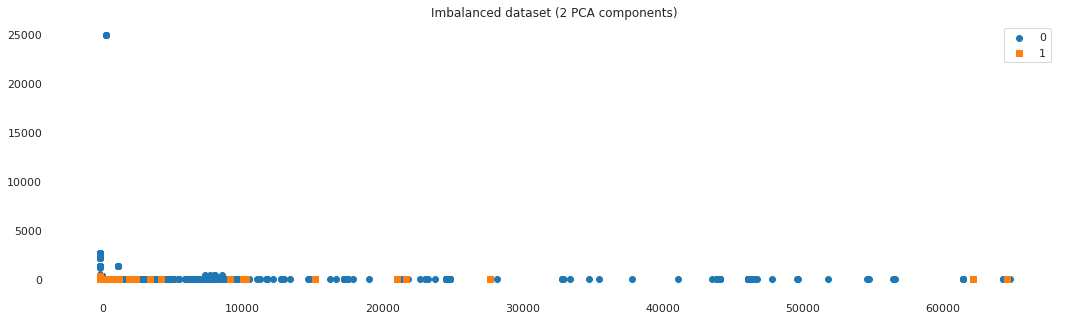

In [1746]:
X = dataset[['attribute2', 'attribute3']]
plot_pca_2d_space(X)

Applying PCA to the group of variables, 'attribute2', 'attribute3', 'attribute4', 'attribute7', and 'attribute9' does not show much difference from PCA applied to 'attribute2' and 'attribute3'. 

If 'attribute1' is included in the first PCA group of variables, then the look of the PCA scatter plot will change.

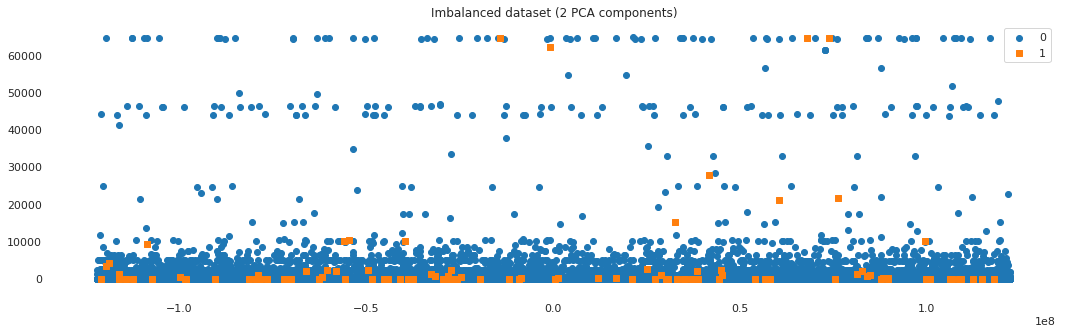

In [1747]:
X = dataset[['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute7', 'attribute9']]
plot_pca_2d_space(X)

If PCA applied to 'attribute1' and 'attribute6',

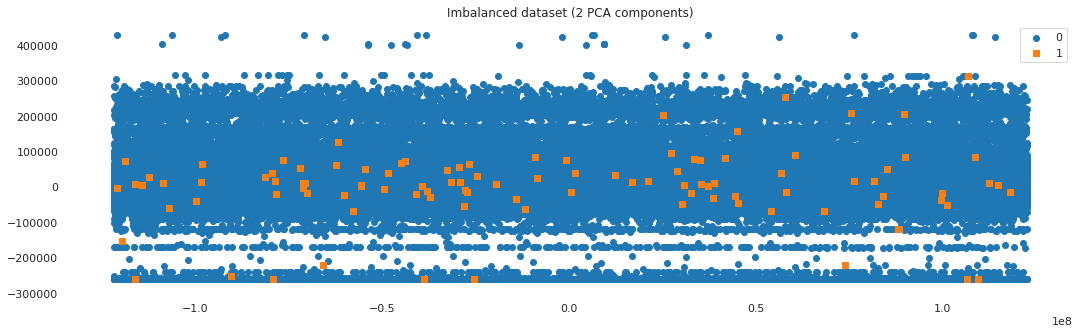

In [1742]:
X = dataset[['attribute1', 'attribute6']]
plot_pca_2d_space(X)

If PCA is applied to 'attribute5' and 'attribute6', 

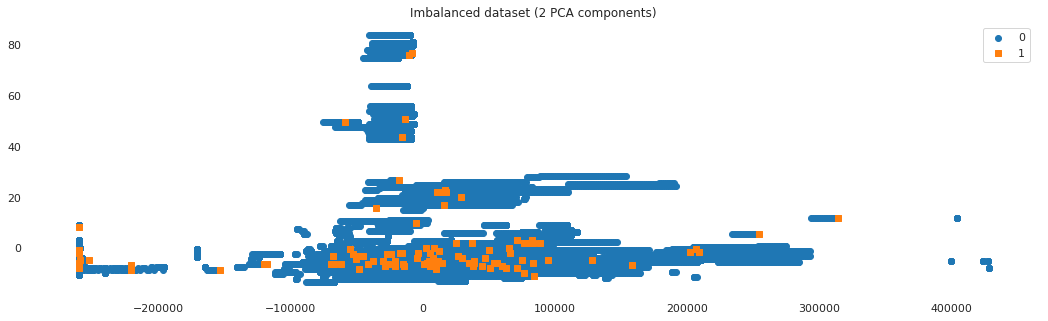

In [1740]:
X = dataset[['attribute5', 'attribute6']]
plot_pca_2d_space(X)

PCA tells some variables can be grouped with similar characteristics and it is a useful way to apply variables when developing the predictive model, regarding those unique characteristics of variables.

Next, a numerial feature importance test can be performed to see how each variable influences on failure and non-failure of the target variable, 'failure'. The feature importance test will be done using ExtraTreesClassifier which is a built in module in sklearn. ExtraTreesClassifier will automatically select the best features by cross-validation and finding their importance in classification using Gini Importance for calculating the feature importance. The following funtion will plot scores for feature importances on each variable.

In [1739]:
# Test features for importances.
def examine_features(x_train, y_train):
    # Build a forest and compute the feature importances
    forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
    forest.fit(x_train, y_train)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(X.shape[1]):
        print("%d. attribute %d (%f)" % (f + 1, indices[f] + 1, importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importance scores")
    plt.bar(range(X.shape[1]), importances[indices],
           color="red", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices+1)
    plt.xlim([-1, X.shape[1]])
    plt.show()

Feature ranking:
1. attribute 1 (0.278196)
2. attribute 6 (0.276792)
3. attribute 4 (0.123269)
4. attribute 2 (0.102534)
5. attribute 5 (0.082676)
6. attribute 7 (0.079533)
7. attribute 8 (0.044559)
8. attribute 3 (0.012441)


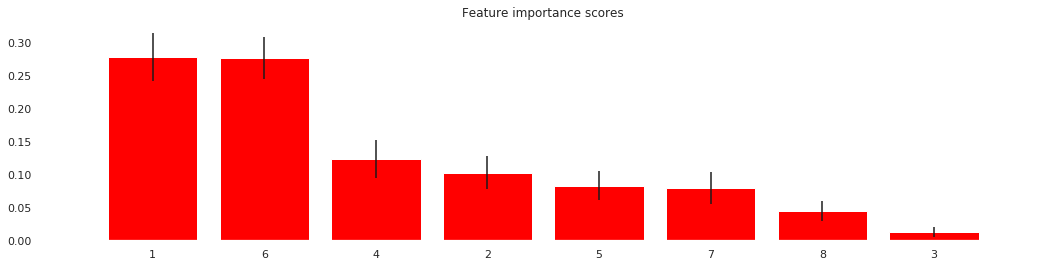

In [1195]:
# Execute feature importance test.
X = dataset[['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']]
Y = dataset.failure
examine_features(X, Y)

The feature importance test would consider that records with failure are not important but records with non-failure are important. So, the feature importance scores would only tell how important those variables are with respect to devices with non-failure. There are only 106 records in the dataset. When ExtraTreesClassifier tests importances of variables, tests are done on reducing the amount of impurity towards non-failure. Is this information useful for the model to be developed? Yes, the information is very useful because the predictive model should also know ways to contribute to non-failure, as well. It should be almost recalled that the goal of the predictive model is not only to detect failure but it must also be able to know how to find a need in a haystack to find devices with failure.

# Model Developments

Several predictive models for classification will be examined, with as many cases as possible, using Random Forest, Gradient Boosting, and XGBoosting, and, at the end, an ensemble of those threee independent classifiers will be examined for performance enhancements. 10-fold-cross-validation is applied by default to generalize variances of model performances. Area-Under-Curve statistic is not provided since it is inappropriate to validate model performances on highly imbalanced datasets. The following measures will be listed out on the console to show how each time the model will act differently on each training dataset during cross-validation.

- Precision
- Recall
- F1 score
- overall-error 

- Average precision
- Average recall
- Average F1 score
- Average overall-eror

Each of measures above have unique characteristics for measurements on model performances.

a handy model generating function would be ideal for repeated model generation declarations. The following model generating function builds classifiers according to the parameters passed from model building processes.

In [1895]:
'''
    Models are built with stratified 10-cross-validation by default. The splitting of data into 
    folds will ensure that each fold has the same proportion of observations with a given 
    categorical value, such as the class outcome value. 
    
    This will produce a predictive model according to a set of function parameters such as:
    - X: holds independent variables.
    - Y: holds the target variable.
    - DEPTH: the maximum number of depths each estimator can span.
    - NEIGHBORS: the number of neighbors to use for data augmentation.
    - ESTIMATORS: the number of estimators.
    - WICH_RF: the choice of model development approaches.(no sampling, over-sampling, smote-sampling)
        1 - SMOTE.
        2 - Random oversampling on minority class.
        0 - No sampling techniques applied.
    
    At the end of the funtion execution, statistical results will be provided on the console.
'''
def run_model(SUMMARY_TABLE, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, WHICH_MODEL, WHICH_SAMPLING):
    predicted = None
    
    # Convert to dataframe to number to split for cross-valation runs.
    numpy_X = X.to_numpy()
    numpy_Y = Y.to_numpy()

    # Create 10-stratified-folds.
    skf = StratifiedKFold(n_splits=10)
    rnd_cnt = 1

    total_fpr = 0
    total_acc = 0
    total_err = 0
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    total_tp = 0
    total_tn = 0
    
    # Run 10-stratified-cross-validations.
    for train_index, test_index in skf.split(numpy_X, numpy_Y):
        # Data is numpied.
        x_train, x_test = numpy_X[train_index], numpy_X[test_index]
        y_train, y_test = numpy_Y[train_index], numpy_Y[test_index]

        # convert to dataframe from numpied data.
        x_train = pd.DataFrame(x_train.reshape(-1, len(X.columns)),columns=X.columns)    
        x_test = pd.DataFrame(x_test.reshape(-1, len(X.columns)),columns=X.columns)
        y_train = pd.DataFrame(y_train.reshape(-1, 1))
        y_test = pd.DataFrame(y_test.reshape(-1, 1))    
        
        
        '''
            Select and do sampling accordingly.
        '''
        if WHICH_SAMPLING == 'SMOTE':  
            # Create random forest classifier with SMOTE-oversampling for the minority class.
            sm = SMOTE(random_state=42, sampling_strategy='not majority', k_neighbors=NEIGHBORS, n_jobs=4)
            x_train_res, y_train_res = sm.fit_sample(x_train, y_train)
            x_train = x_train_res
            y_train = y_train_res
            
        elif WHICH_SAMPLING == 'OVER': 
            # Run the model with over-sampling for samples of minority class
            # Concatenate y_train to x_train to over-sample".
            train_dataset = x_train
            train_dataset['failure'] = y_train

            # Split train dataset into true negatives and true positives
            train_target_0 = train_dataset[train_dataset.iloc[:,-1] == 0]
            train_target_1 = train_dataset[train_dataset.iloc[:,-1] == 1]

            
            #Over-sample data with replacement allowed for the minority class.
            train_target_1_oversample = train_target_1.sample(len(train_target_0), replace=True)
            train_target_1_oversample.failure.value_counts()
            train_oversample = pd.concat([train_target_1_oversample, train_target_0], axis=0)

            x_train = train_oversample # Assign over-sampled train dataset to x_train.
            y_train = x_train.failure # Copy y values from x_train.
            x_train.drop('failure', axis=1, inplace=True) # Drop y values from x_train.
        
        elif WHICH_SAMPLING == 'UNDER':
            train_dataset = x_train
            train_dataset['failure'] = y_train
            
            
            
            rus = RandomUnderSampler(random_state=0, ratio={0: 1000, 1: 106})
            rus.fit(X, y)
            X_resampled, y_resampled = rus.sample(X, y)

            
        else: 
            pass
        
        '''
            Select and run the model accordingly.
        '''
        if WHICH_MODEL == 'RF': # Random Forest.
            rf = RandomForestClassifier(random_state=0, n_estimators=ESTIMATORS, max_depth=DEPTH)
            rf.fit(x_train,y_train) # Fit the model to training dataset.
            predicted = rf.predict(x_test) # Get prediction result.
            
        elif WHICH_MODEL == 'GB': # Gradient Boosting.
            gbc = GradientBoostingClassifier(random_state=0, max_depth=DEPTH, learning_rate=0.01) # learning_rate=0.1 by default
            gbc.fit(x_train, y_train)
            predicted = gbc.predict(x_test) # Get prediction result.

        else: # Ensemble of independent classifiers.
            gb = GradientBoostingClassifier(n_estimators=ESTIMATORS, learning_rate=0.01)
            rf = RandomForestClassifier(random_state=0, n_estimators=ESTIMATORS, max_depth=DEPTH)
            ada = AdaBoostClassifier(n_estimators=200, learning_rate=0.01)

            voting_clf = VotingClassifier(estimators=[('gb', gb), ('rf', rf), ('ada', ada)], voting='hard')
            voting_clf.fit(x_train, y_train)
            predicted = voting_clf.predict(x_test)
        
        
        # Show statistics for each round.
        print("Fold - {}".format(rnd_cnt))
        '''
            Confusion Matrix
        '''
        print("-------------  Confusion Matrix  ----------------")
        cm = confusion_matrix(y_test, predicted)
        print(cm)
        
        '''
            Get individual counts from confusion matrix for further statistics for 
            true positive, true negatve, false positive, and false negative.
        '''
        TN = cm[0][0]
        FP = cm[0][1]
        FN = cm[1][0]
        TP = cm[1][1]
        
        # Compute totals of true positives and true negatives.
        total_tp += TP
        total_tn += TN
        
        '''
            Statistics for accuray, precision, recall, overall error, and etc..
        '''
        print("-------------     Statistics     ----------------")
        acc = (TN+TP)/(TN+TP+FP+FN)
        precision = (TP)/(TP+FP)
        recall = (TP)/(TP+FN)
        f1 = 2 * (precision*recall/(precision+recall))
        overall_error = (FP+FN)/(TP+TN+FP+FN)     
        fpr = (FP)/(TN+FP)
        
        print("Acc.: {:.3f}%\t Prec.: {:.3f}%\t Rec.: {:.3f}%\t F1: {:.3f}%\t Err.: {:.3f}%\t FPR: {:.3f}\tTP: {}\t TN: {}".
            format(
                round(acc, 4)*100, 
                round(precision, 4)*100, 
                round(recall, 4)*100, 
                round(f1, 4)*100,
                round(overall_error, 4)*100,
                round(fpr, 4)*100,
                TP,
                TN
            ))
        print("\n")
        
        # Compute totals of other statistics.
        total_err += overall_error
        total_acc += acc
        total_precision += precision
        total_recall += recall
        total_f1 += f1
        total_fpr += fpr
        
        # Increment round by 1.
        rnd_cnt += 1
    
    # Compute averages.
    avg_err = round((total_err/10)*100, 4)
    avg_acc = round((total_acc/10)*100, 4)
    avg_pre = round((total_precision/10)*100, 4)
    avg_rec = round((total_recall/10)*100, 4)
    avg_f1 = round((total_f1/10)*100, 4)
    avg_tp = round((total_tp/10), 2)
    avg_tn = round((total_tn/10), 2)
    avg_fpr = round((total_fpr/10), 4)
    
    print("-------- Average Statistics ---------")
    print("Acc.: {:.3f}%\t Pre. {:.3f}%\t Rec.: {:.3f}%\t F1: {:.3f}\t FPR: {:.3f}\t Err.: {:.3f}%\t TP: {:.3f}\t TN: {:.3f}".
        format(avg_acc, avg_pre, avg_rec, avg_f1, avg_fpr, avg_err, avg_tp, avg_tn))
    show_classifier_summary(SUMMARY_TABLE, WHICH_MODEL, WHICH_SAMPLING, len(X.columns), avg_acc, avg_pre, avg_rec, avg_fpr, avg_err, avg_f1, avg_tp, avg_tn, X)

In [1893]:
def show_classifier_summary(summary_table, which_model, 
                            which_sample_tech, 
                            var_len,
                            avg_acc, 
                            avg_pre, 
                            avg_rec, 
                            avg_fpr,
                            avg_err, 
                            avg_f1,
                            avg_tp, 
                            avg_tn, 
                            variables):
    
    precision_summary_table.append(avg_pre)
    recall_summary_table.append(avg_rec)
    no_of_variables.append(var_len)
    
    summary_table.append(
            [which_model, 
            which_sample_tech, 
            var_len,                             
            avg_acc, 
            avg_pre,
            avg_rec,
            avg_fpr,
            avg_err, 
            avg_tp, 
            avg_tn, 
            variables.columns.tolist()]
        )
    display(HTML(tabulate.tabulate(summary_table, tablefmt='html')))

## Random Forest Classifier

Random Forest is an ensemble method. An ensemble of many week leaners. Ensembles are a divide-and-conquer approach used to improve performance. The main principle behind ensemble methods is that a group of weak learners can come together to form a strong learner. Each learner is a single decision tree. Random Forest creates many decision trees and combine all the trees for prediction. A single decision tree tends to overfit the training dataset, so the variances becomes large bewteen different datasets. However, Random Forest does not guranttee it does not perfectly avoide overfitting but it is less overfitted with a generalization of variances of many weak learners.

### Random Forest classifier without sampling

Predictive model development will start with all the variables of the dataset applied. The model will run without and with sampling techniques applied to see the differences between the two cases. First, the model will run with no sampling techniques applied including all the variables in the dataset.

In [1900]:
rf_summary_table = [["MODEL", "SAMPLING", "NO_VARS", "ACC.", "PRE.", "REC.", "FPR.", "ERR.", "TP", "TN", "VARS."]]

precision_summary_table = []
recall_summary_table = []
no_of_variables = []

# Set variables to be participated in the model.
X = dataset[['attribute1', 'attribute2', 'attribute3', 'attribute4','attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']]
Y = dataset.failure
DEPTH = 7 # Define the max depth to 7.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(rf_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'RF', 'NO') # 0 for random forest without oversampling

Fold - 1
-------------  Confusion Matrix  ----------------
[[12437     2]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.900%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.100%	 FPR: 0.020	TP: 0	 TN: 12437


Fold - 2
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 3
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 4
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 5
-------------  Confusion Matrix  ------

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
RF,NO,9,99.89,0.0,0.0,0.0002,0.11,0.0,12435.7,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']"


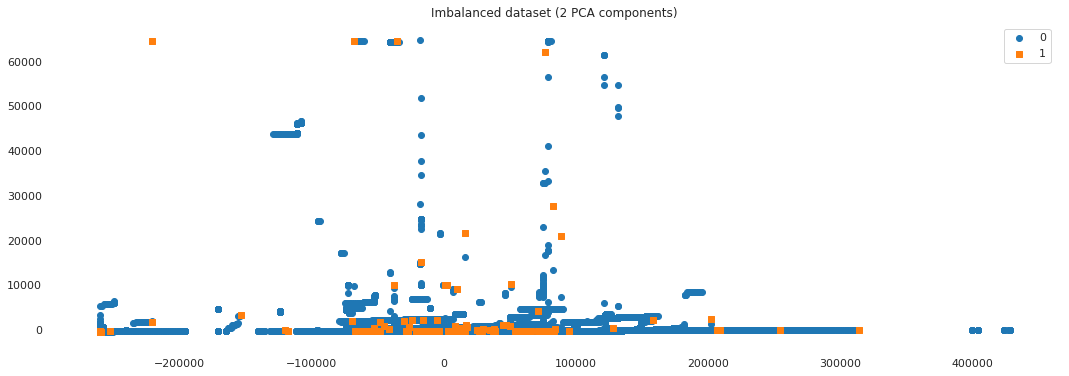

In [1901]:
X = dataset[['attribute2', 'attribute5', 'attribute6']]
plot_pca_2d_space(X)

In [1902]:
# Set variables to be participated in the model.
X = dataset[['attribute2', 'attribute5', 'attribute6']]
Y = dataset.failure
DEPTH = 3 # Define the max depth to 3 since there are only 3 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(rf_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'RF', 'NO')

Fold - 1
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 2
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 3
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 4
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 5
-------------  Confusion Matrix  ------

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
RF,NO,9,99.89,0.0,0.0,0.0002,0.11,0.0,12435.7,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute5', 'attribute6']"


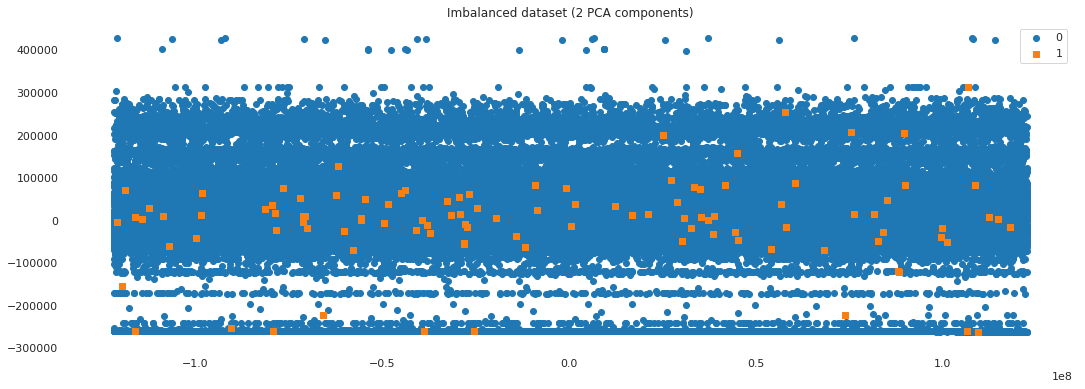

In [1903]:
X = dataset[['attribute1', 'attribute2', 'attribute4', 'attribute6']]
plot_pca_2d_space(X)

In [1904]:
X = dataset[['attribute1', 'attribute2', 'attribute4', 'attribute6']]
Y = dataset.failure
DEPTH = 4 # Define the max depth to 4 since there are only 3 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(rf_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'RF', 'NO')

Fold - 1
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 2
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 3
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 4
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 5
-------------  Confusion Matrix  ------

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
RF,NO,9,99.89,0.0,0.0,0.0002,0.11,0.0,12435.7,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute5', 'attribute6']"
RF,NO,4,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"


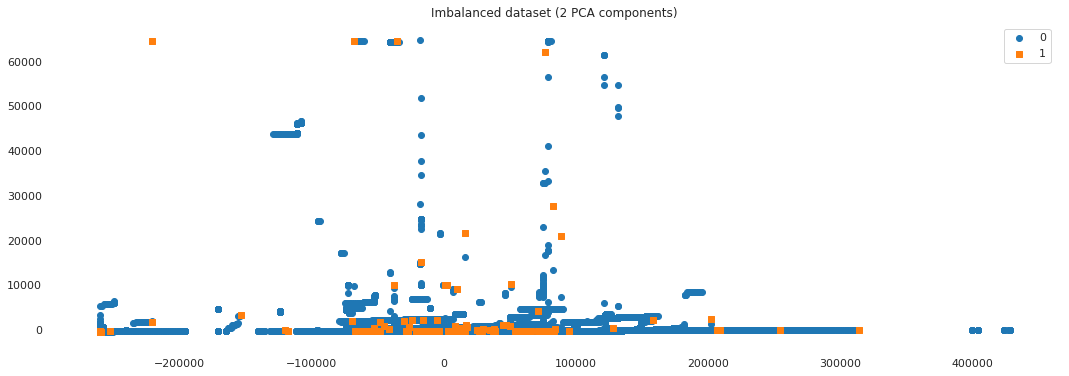

In [1905]:
X = dataset[['attribute2', 'attribute4', 'attribute6']]
plot_pca_2d_space(X)

In [1906]:
# Set variables to be participated in the model development.
X = dataset[['attribute2', 'attribute4', 'attribute6']]
Y = dataset.failure
DEPTH = 3 # Define the max depth to 4 since there are only 3 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(rf_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'RF', 'NO')

Fold - 1
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 2
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 3
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 4
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 5
-------------  Confusion Matrix  ------

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
RF,NO,9,99.89,0.0,0.0,0.0002,0.11,0.0,12435.7,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute5', 'attribute6']"
RF,NO,4,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute4', 'attribute6']"


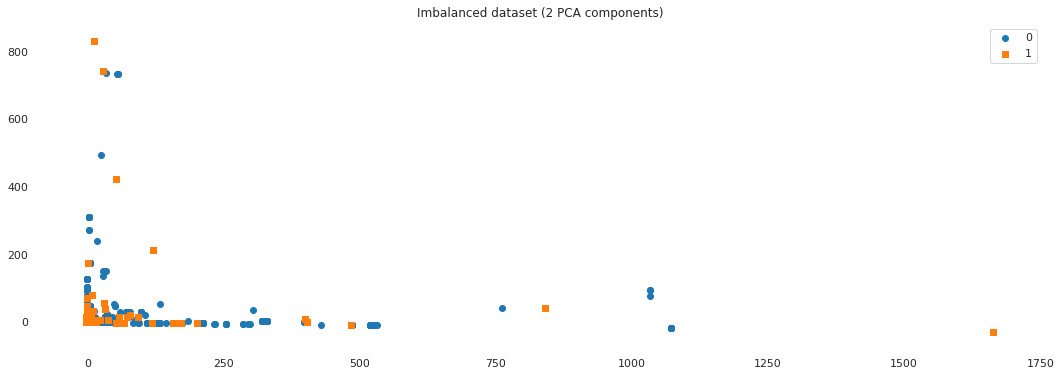

In [1907]:
X = dataset[['attribute4', 'attribute7']]
plot_pca_2d_space(X)

In [1908]:
# Set variables to be participated in the model.
X = dataset[['attribute4', 'attribute7']]
Y = dataset.failure
DEPTH = 2 # Define the max depth to 4 since there are only 4 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(rf_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'RF', 'NO')

Fold - 1
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 2
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 3
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 4
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 5
-------------  Confusion Matrix  ------

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
RF,NO,9,99.89,0.0,0.0,0.0002,0.11,0.0,12435.7,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute5', 'attribute6']"
RF,NO,4,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute4', 'attribute6']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"


In [1909]:
# Set variables to be participated in the model.
X = dataset[['attribute4', 'attribute7']]
Y = dataset.failure
DEPTH = 2 # Define the max depth to 4 since there are only 4 variable to join in the model development.
ESTIMATORS = 150 # No. of estimators changed to 150 from 100.
NEIGHBORS = 0
run_model(rf_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'RF', 'NO') 

Fold - 1
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 2
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 3
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 4
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 5
-------------  Confusion Matrix  ------

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
RF,NO,9,99.89,0.0,0.0,0.0002,0.11,0.0,12435.7,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute5', 'attribute6']"
RF,NO,4,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute4', 'attribute6']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"


The model did not detect any true positives, devices with failure, at alll. The number of records indicating devices with failure is less than 1% of the total records, it is unlikely that the model would get a chance to pick devices with failure. This time, the number of variables participated in the model development are reduced to 3 without sampling techniques. 3 variables of the dataset are chosen and will be tested for the model development. Neither including all the variables in the dataset nor reducing the number of variables did not improve the model performance, at all. 

### Random Forest classifier with over-sampling

Oversampling might be some help for the model to detect true positives. Before oversampling, it would be nice to see what difference oversampling would make. The following lines will create a numerical analysis to find associations among variables. Let's try oversampling and see what has changed between the two datasets after oversampling. Oversampling is randomly done with replacement. The following precedures will perform oversampling on the minority class, 'failure'.

In [1910]:
# Class count
count_non_failure, count_failure = dataset.failure.value_counts()
print("No. of non-failures: {}\t No. of failures: {}".format(count_non_failure, count_failure))

No. of non-failures: 124388	 No. of failures: 106


In [1911]:
# Divide by class
df_failure = dataset[dataset['failure'] == 1]
df_non_failure = dataset[dataset['failure'] == 0]

In [1912]:
print(df_failure.count())

date          106
device        106
failure       106
attribute1    106
attribute2    106
attribute3    106
attribute4    106
attribute5    106
attribute6    106
attribute7    106
attribute8    106
attribute9    106
dtype: int64


In [1913]:
df_failure_over = df_failure.sample(count_non_failure, replace=True)

In [1914]:
oversampled_dataset = pd.concat([df_non_failure, df_failure_over], axis=0)
print(oversampled_dataset.count())

date          248776
device        248776
failure       248776
attribute1    248776
attribute2    248776
attribute3    248776
attribute4    248776
attribute5    248776
attribute6    248776
attribute7    248776
attribute8    248776
attribute9    248776
dtype: int64


Random over-sampling:
1    124388
0    124388
Name: failure, dtype: int64


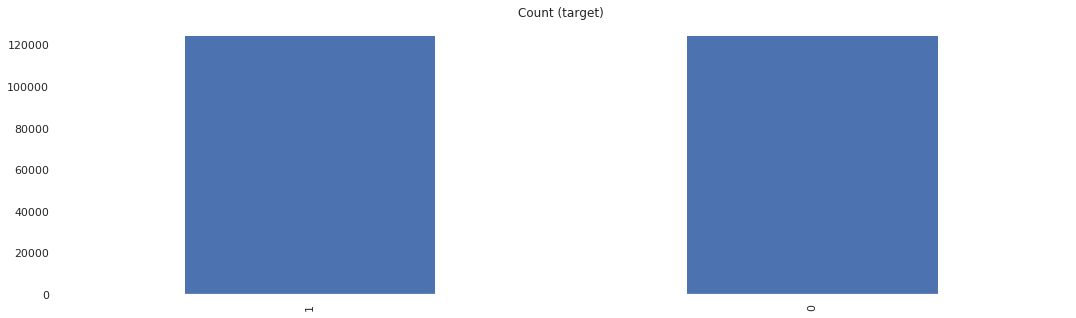

In [1915]:
plt.rcParams['figure.figsize'] = (18.0, 5.0)
print('Random over-sampling:')
print(oversampled_dataset.failure.value_counts())
oversampled_dataset.failure.value_counts().plot(kind='bar', title='Count (target)');

Now, the two classes are balanced with oversampling. It might be good if feature importance tests can be done on the oversample dataset and the original dataset. The following lines will show two independent feature importance tests.

Feature importance test on oversampled dataset
Feature ranking:
1. attribute 4 (0.185060)
2. attribute 1 (0.182288)
3. attribute 6 (0.162830)
4. attribute 7 (0.148049)
5. attribute 2 (0.145149)
6. attribute 5 (0.124196)
7. attribute 8 (0.033790)
8. attribute 3 (0.018639)


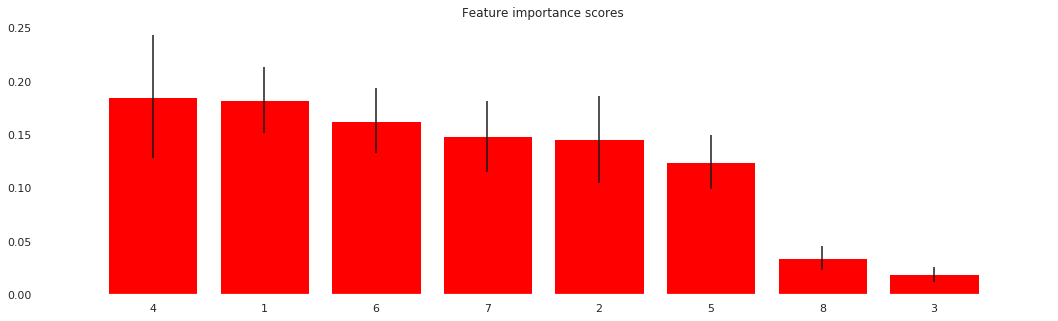

Feature importance test on original dataset
Feature ranking:
1. attribute 1 (0.278196)
2. attribute 6 (0.276792)
3. attribute 4 (0.123269)
4. attribute 2 (0.102534)
5. attribute 5 (0.082676)
6. attribute 7 (0.079533)
7. attribute 8 (0.044559)
8. attribute 3 (0.012441)


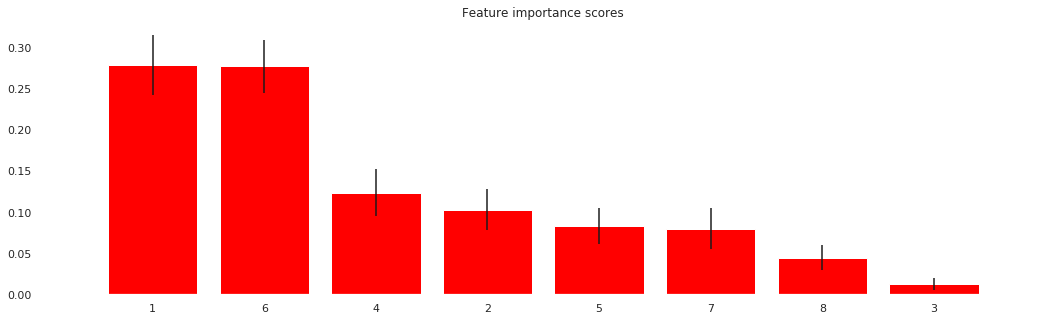

In [1916]:
print("Feature importance test on oversampled dataset")
X = oversampled_dataset[['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']]
Y = oversampled_dataset.failure
examine_features(X,Y)

print("Feature importance test on original dataset")
X = dataset[['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']]
Y = dataset.failure
examine_features(X,Y)

Oversampling has shown that it does rearrange importances of features with importance scores. Next, the model development will be examined with over-sampling for the performance of the predictive model. First, all the variables in the dataset will participate in the model development.

In [1917]:
# Statistics to plot recall and precision line graphs.
recall_summary_table = []
precision_summary_table = []
no_of_variables = []

# Set variables to be participated in the model development.
X = dataset[['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']]
Y = dataset.failure

DEPTH = 8 # Define the max depth to 8 since there are 8 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(rf_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'RF', 'OVERSAMPLING')

Fold - 1
-------------  Confusion Matrix  ----------------
[[12097   342]
 [    9     2]]
-------------     Statistics     ----------------
Acc.: 97.180%	 Prec.: 0.580%	 Rec.: 18.180%	 F1: 1.130%	 Err.: 2.820%	 FPR: 2.750	TP: 2	 TN: 12097


Fold - 2
-------------  Confusion Matrix  ----------------
[[12069   370]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 97.000%	 Prec.: 1.860%	 Rec.: 63.640%	 F1: 3.610%	 Err.: 3.000%	 FPR: 2.970	TP: 7	 TN: 12069


Fold - 3
-------------  Confusion Matrix  ----------------
[[12046   393]
 [    6     5]]
-------------     Statistics     ----------------
Acc.: 96.800%	 Prec.: 1.260%	 Rec.: 45.450%	 F1: 2.440%	 Err.: 3.200%	 FPR: 3.160	TP: 5	 TN: 12046


Fold - 4
-------------  Confusion Matrix  ----------------
[[12132   307]
 [    8     3]]
-------------     Statistics     ----------------
Acc.: 97.470%	 Prec.: 0.970%	 Rec.: 27.270%	 F1: 1.870%	 Err.: 2.530%	 FPR: 2.470	TP: 3	 TN: 12132


Fold - 5
-------------  Confusion Ma

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
RF,NO,9,99.89,0.0,0.0,0.0002,0.11,0.0,12435.7,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute5', 'attribute6']"
RF,NO,4,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute4', 'attribute6']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,OVERSAMPLING,8,97.3533,1.056,32.9091,0.0259,2.6467,3.5,12116.4,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"


In [1918]:
# Set variables to be participated in the model development.
X = dataset[['attribute2', 'attribute5', 'attribute6']]
Y = dataset.failure
DEPTH = 3 # Define the max depth to 3 since there are only 3 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(rf_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'RF', 'OVERSAMPLING')

Fold - 1
-------------  Confusion Matrix  ----------------
[[11099  1340]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 89.200%	 Prec.: 0.520%	 Rec.: 63.640%	 F1: 1.030%	 Err.: 10.800%	 FPR: 10.770	TP: 7	 TN: 11099


Fold - 2
-------------  Confusion Matrix  ----------------
[[10802  1637]
 [    6     5]]
-------------     Statistics     ----------------
Acc.: 86.800%	 Prec.: 0.300%	 Rec.: 45.450%	 F1: 0.600%	 Err.: 13.200%	 FPR: 13.160	TP: 5	 TN: 10802


Fold - 3
-------------  Confusion Matrix  ----------------
[[11737   702]
 [    5     6]]
-------------     Statistics     ----------------
Acc.: 94.320%	 Prec.: 0.850%	 Rec.: 54.550%	 F1: 1.670%	 Err.: 5.680%	 FPR: 5.640	TP: 6	 TN: 11737


Fold - 4
-------------  Confusion Matrix  ----------------
[[10859  1580]
 [    6     5]]
-------------     Statistics     ----------------
Acc.: 87.260%	 Prec.: 0.320%	 Rec.: 45.450%	 F1: 0.630%	 Err.: 12.740%	 FPR: 12.700	TP: 5	 TN: 10859


Fold - 5
-------------  Confus

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
RF,NO,9,99.89,0.0,0.0,0.0002,0.11,0.0,12435.7,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute5', 'attribute6']"
RF,NO,4,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute4', 'attribute6']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,OVERSAMPLING,8,97.3533,1.056,32.9091,0.0259,2.6467,3.5,12116.4,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
RF,OVERSAMPLING,3,88.258,0.3627,46.1818,0.1171,11.742,4.9,10982.7,"['attribute2', 'attribute5', 'attribute6']"


In [1919]:
# Set variables to be participated in the model development.
X = dataset[['attribute1', 'attribute2', 'attribute4', 'attribute6']]
Y = dataset.failure
DEPTH = 4 # Define the max depth to 4 since there are 4 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(rf_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'RF', 'OVERSAMPLING')

Fold - 1
-------------  Confusion Matrix  ----------------
[[11084  1355]
 [    5     6]]
-------------     Statistics     ----------------
Acc.: 89.080%	 Prec.: 0.440%	 Rec.: 54.550%	 F1: 0.870%	 Err.: 10.920%	 FPR: 10.890	TP: 6	 TN: 11084


Fold - 2
-------------  Confusion Matrix  ----------------
[[11447   992]
 [    2     9]]
-------------     Statistics     ----------------
Acc.: 92.020%	 Prec.: 0.900%	 Rec.: 81.820%	 F1: 1.780%	 Err.: 7.980%	 FPR: 7.970	TP: 9	 TN: 11447


Fold - 3
-------------  Confusion Matrix  ----------------
[[11324  1115]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 91.010%	 Prec.: 0.620%	 Rec.: 63.640%	 F1: 1.240%	 Err.: 8.990%	 FPR: 8.960	TP: 7	 TN: 11324


Fold - 4
-------------  Confusion Matrix  ----------------
[[11440   999]
 [    3     8]]
-------------     Statistics     ----------------
Acc.: 91.950%	 Prec.: 0.790%	 Rec.: 72.730%	 F1: 1.570%	 Err.: 8.050%	 FPR: 8.030	TP: 8	 TN: 11440


Fold - 5
-------------  Confusion 

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
RF,NO,9,99.89,0.0,0.0,0.0002,0.11,0.0,12435.7,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute5', 'attribute6']"
RF,NO,4,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute4', 'attribute6']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,OVERSAMPLING,8,97.3533,1.056,32.9091,0.0259,2.6467,3.5,12116.4,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
RF,OVERSAMPLING,3,88.258,0.3627,46.1818,0.1171,11.742,4.9,10982.7,"['attribute2', 'attribute5', 'attribute6']"
RF,OVERSAMPLING,4,91.8205,0.6597,63.0909,0.0816,8.1795,6.7,11424.4,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"


In [1920]:
# Set variables to be participated in the model development.
X = dataset[['attribute2', 'attribute4', 'attribute6']]
Y = dataset.failure
DEPTH = 3 # Define the max depth to 3 since there are only 3 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(rf_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'RF', 'OVERSAMPLING')

Fold - 1
-------------  Confusion Matrix  ----------------
[[10779  1660]
 [    3     8]]
-------------     Statistics     ----------------
Acc.: 86.640%	 Prec.: 0.480%	 Rec.: 72.730%	 F1: 0.950%	 Err.: 13.360%	 FPR: 13.350	TP: 8	 TN: 10779


Fold - 2
-------------  Confusion Matrix  ----------------
[[11095  1344]
 [    1    10]]
-------------     Statistics     ----------------
Acc.: 89.200%	 Prec.: 0.740%	 Rec.: 90.910%	 F1: 1.470%	 Err.: 10.800%	 FPR: 10.800	TP: 10	 TN: 11095


Fold - 3
-------------  Confusion Matrix  ----------------
[[11102  1337]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 89.230%	 Prec.: 0.520%	 Rec.: 63.640%	 F1: 1.030%	 Err.: 10.770%	 FPR: 10.750	TP: 7	 TN: 11102


Fold - 4
-------------  Confusion Matrix  ----------------
[[11209  1230]
 [    3     8]]
-------------     Statistics     ----------------
Acc.: 90.100%	 Prec.: 0.650%	 Rec.: 72.730%	 F1: 1.280%	 Err.: 9.900%	 FPR: 9.890	TP: 8	 TN: 11209


Fold - 5
-------------  Confu

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
RF,NO,9,99.89,0.0,0.0,0.0002,0.11,0.0,12435.7,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute5', 'attribute6']"
RF,NO,4,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute4', 'attribute6']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,OVERSAMPLING,8,97.3533,1.056,32.9091,0.0259,2.6467,3.5,12116.4,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
RF,OVERSAMPLING,3,88.258,0.3627,46.1818,0.1171,11.742,4.9,10982.7,"['attribute2', 'attribute5', 'attribute6']"
RF,OVERSAMPLING,4,91.8205,0.6597,63.0909,0.0816,8.1795,6.7,11424.4,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,OVERSAMPLING,3,89.7168,0.561,67.7273,0.1026,10.2832,7.2,11162.0,"['attribute2', 'attribute4', 'attribute6']"


In [1921]:
# Set variables to be participated in the model development.
X = dataset[['attribute4', 'attribute7']]
Y = dataset.failure
DEPTH = 2 # Define the max depth to 2 since there are only 2 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting
NEIGHBORS = 0
run_model(rf_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'RF', 'OVERSAMPLING')

Fold - 1
-------------  Confusion Matrix  ----------------
[[11113  1326]
 [    2     9]]
-------------     Statistics     ----------------
Acc.: 89.330%	 Prec.: 0.670%	 Rec.: 81.820%	 F1: 1.340%	 Err.: 10.670%	 FPR: 10.660	TP: 9	 TN: 11113


Fold - 2
-------------  Confusion Matrix  ----------------
[[11493   946]
 [    0    11]]
-------------     Statistics     ----------------
Acc.: 92.400%	 Prec.: 1.150%	 Rec.: 100.000%	 F1: 2.270%	 Err.: 7.600%	 FPR: 7.610	TP: 11	 TN: 11493


Fold - 3
-------------  Confusion Matrix  ----------------
[[11507   932]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 92.480%	 Prec.: 0.750%	 Rec.: 63.640%	 F1: 1.470%	 Err.: 7.520%	 FPR: 7.490	TP: 7	 TN: 11507


Fold - 4
-------------  Confusion Matrix  ----------------
[[11516   923]
 [    5     6]]
-------------     Statistics     ----------------
Acc.: 92.550%	 Prec.: 0.650%	 Rec.: 54.550%	 F1: 1.280%	 Err.: 7.450%	 FPR: 7.420	TP: 6	 TN: 11516


Fold - 5
-------------  Confusio

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
RF,NO,9,99.89,0.0,0.0,0.0002,0.11,0.0,12435.7,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute5', 'attribute6']"
RF,NO,4,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute4', 'attribute6']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,OVERSAMPLING,8,97.3533,1.056,32.9091,0.0259,2.6467,3.5,12116.4,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
RF,OVERSAMPLING,3,88.258,0.3627,46.1818,0.1171,11.742,4.9,10982.7,"['attribute2', 'attribute5', 'attribute6']"
RF,OVERSAMPLING,4,91.8205,0.6597,63.0909,0.0816,8.1795,6.7,11424.4,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,OVERSAMPLING,3,89.7168,0.561,67.7273,0.1026,10.2832,7.2,11162.0,"['attribute2', 'attribute4', 'attribute6']"


In [1922]:
# Set variables to be participated in the model development.
X = dataset[['attribute4', 'attribute7']]
Y = dataset.failure
DEPTH = 2 # Define the max depth to 2 since there are only 2 variable to join in the model development.
ESTIMATORS = 150 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(rf_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'RF', 'OVERSAMPLING')

Fold - 1
-------------  Confusion Matrix  ----------------
[[11113  1326]
 [    2     9]]
-------------     Statistics     ----------------
Acc.: 89.330%	 Prec.: 0.670%	 Rec.: 81.820%	 F1: 1.340%	 Err.: 10.670%	 FPR: 10.660	TP: 9	 TN: 11113


Fold - 2
-------------  Confusion Matrix  ----------------
[[11493   946]
 [    0    11]]
-------------     Statistics     ----------------
Acc.: 92.400%	 Prec.: 1.150%	 Rec.: 100.000%	 F1: 2.270%	 Err.: 7.600%	 FPR: 7.610	TP: 11	 TN: 11493


Fold - 3
-------------  Confusion Matrix  ----------------
[[11507   932]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 92.480%	 Prec.: 0.750%	 Rec.: 63.640%	 F1: 1.470%	 Err.: 7.520%	 FPR: 7.490	TP: 7	 TN: 11507


Fold - 4
-------------  Confusion Matrix  ----------------
[[11516   923]
 [    5     6]]
-------------     Statistics     ----------------
Acc.: 92.550%	 Prec.: 0.650%	 Rec.: 54.550%	 F1: 1.280%	 Err.: 7.450%	 FPR: 7.420	TP: 6	 TN: 11516


Fold - 5
-------------  Confusio

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
RF,NO,9,99.89,0.0,0.0,0.0002,0.11,0.0,12435.7,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute5', 'attribute6']"
RF,NO,4,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute4', 'attribute6']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,OVERSAMPLING,8,97.3533,1.056,32.9091,0.0259,2.6467,3.5,12116.4,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
RF,OVERSAMPLING,3,88.258,0.3627,46.1818,0.1171,11.742,4.9,10982.7,"['attribute2', 'attribute5', 'attribute6']"
RF,OVERSAMPLING,4,91.8205,0.6597,63.0909,0.0816,8.1795,6.7,11424.4,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,OVERSAMPLING,3,89.7168,0.561,67.7273,0.1026,10.2832,7.2,11162.0,"['attribute2', 'attribute4', 'attribute6']"


Text(0, 0.5, 'Recall scores')

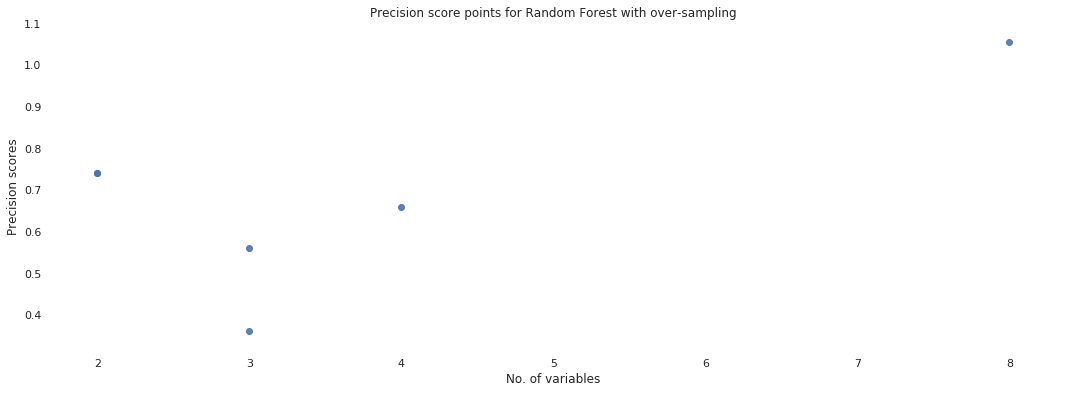

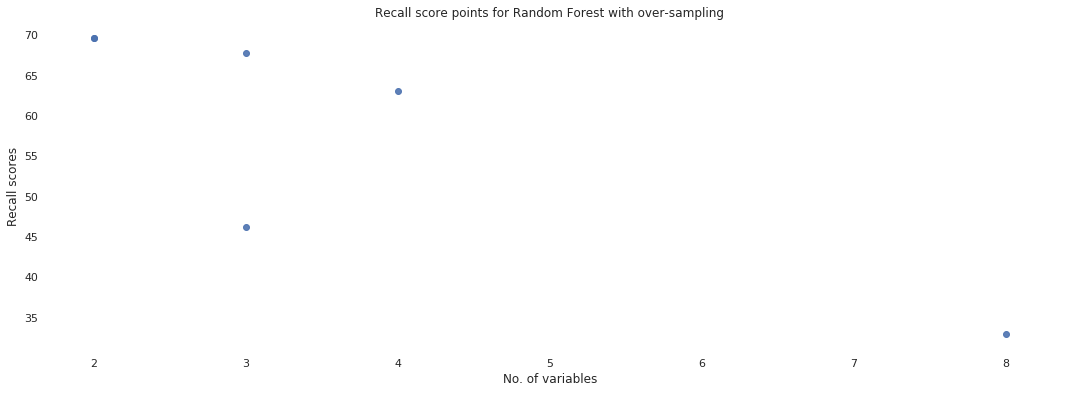

In [1923]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
fig, ax = plt.subplots()
ax.scatter(no_of_variables, precision_summary_table, alpha=0.9)
ax.set_title('Precision score points for Random Forest with over-sampling')
ax.set_xlabel('No. of variables')
ax.set_ylabel('Precision scores')

plt.rcParams['figure.figsize'] = (18.0, 6.0)
fig, ax = plt.subplots()
ax.scatter(no_of_variables, recall_summary_table, alpha=0.9)
ax.set_title('Recall score points for Random Forest with over-sampling')
ax.set_xlabel('No. of variables')
ax.set_ylabel('Recall scores')

The predictive model has become able to tell the difference between failure and non-failure. Next, the reduced number of variables will be randomly chosen and applied to the model development. Although over-sampling helps the predictive model detect devices with failure, variables to be used should be chosen by understanding distributions of contributions of unique values of those variables.

With no sampling, the predictive model was unable to tell the difference between failure and non-failure but ,with over-sampling, it can surely tell what the difference between them is. A different sampling technique might show a different model performance. This time, SMOTE sampling will be used to generate synthetic data for the model. First, all the variables will participate in the model development and later, a reduced number of variables will be applied to see the difference between them.

### Random Forest classifier with SMOTE

In [1924]:
recall_summary_table = []
precision_summary_table = []
no_of_variables = []

# Set variables to be participated in the model development.
X = dataset[['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']]
Y = dataset.failure
DEPTH = 8 # Define the max depth to 8 since there are 8 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 2
run_model(rf_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'RF', 'SMOTE')

Fold - 1
-------------  Confusion Matrix  ----------------
[[11815   624]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 94.960%	 Prec.: 1.110%	 Rec.: 63.640%	 F1: 2.180%	 Err.: 5.040%	 FPR: 5.020	TP: 7	 TN: 11815


Fold - 2
-------------  Confusion Matrix  ----------------
[[11972   467]
 [    2     9]]
-------------     Statistics     ----------------
Acc.: 96.230%	 Prec.: 1.890%	 Rec.: 81.820%	 F1: 3.700%	 Err.: 3.770%	 FPR: 3.750	TP: 9	 TN: 11972


Fold - 3
-------------  Confusion Matrix  ----------------
[[12064   375]
 [    3     8]]
-------------     Statistics     ----------------
Acc.: 96.960%	 Prec.: 2.090%	 Rec.: 72.730%	 F1: 4.060%	 Err.: 3.040%	 FPR: 3.010	TP: 8	 TN: 12064


Fold - 4
-------------  Confusion Matrix  ----------------
[[12167   272]
 [    6     5]]
-------------     Statistics     ----------------
Acc.: 97.770%	 Prec.: 1.810%	 Rec.: 45.450%	 F1: 3.470%	 Err.: 2.230%	 FPR: 2.190	TP: 5	 TN: 12167


Fold - 5
-------------  Confusion Ma

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
RF,NO,9,99.89,0.0,0.0,0.0002,0.11,0.0,12435.7,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute5', 'attribute6']"
RF,NO,4,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute4', 'attribute6']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,OVERSAMPLING,8,97.3533,1.056,32.9091,0.0259,2.6467,3.5,12116.4,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
RF,OVERSAMPLING,3,88.258,0.3627,46.1818,0.1171,11.742,4.9,10982.7,"['attribute2', 'attribute5', 'attribute6']"
RF,OVERSAMPLING,4,91.8205,0.6597,63.0909,0.0816,8.1795,6.7,11424.4,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,OVERSAMPLING,3,89.7168,0.561,67.7273,0.1026,10.2832,7.2,11162.0,"['attribute2', 'attribute4', 'attribute6']"


In [1925]:
# Set variables to be participated in the model development.
X = dataset[['attribute2', 'attribute5', 'attribute6']]
Y = dataset.failure
DEPTH = 3 # Define the max depth to 3 since there are only 3 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 2
run_model(rf_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'RF', 'SMOTE')

Fold - 1
-------------  Confusion Matrix  ----------------
[[10882  1557]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 87.460%	 Prec.: 0.450%	 Rec.: 63.640%	 F1: 0.890%	 Err.: 12.540%	 FPR: 12.520	TP: 7	 TN: 10882


Fold - 2
-------------  Confusion Matrix  ----------------
[[11199  1240]
 [    7     4]]
-------------     Statistics     ----------------
Acc.: 89.980%	 Prec.: 0.320%	 Rec.: 36.360%	 F1: 0.640%	 Err.: 10.020%	 FPR: 9.970	TP: 4	 TN: 11199


Fold - 3
-------------  Confusion Matrix  ----------------
[[11759   680]
 [    5     6]]
-------------     Statistics     ----------------
Acc.: 94.500%	 Prec.: 0.870%	 Rec.: 54.550%	 F1: 1.720%	 Err.: 5.500%	 FPR: 5.470	TP: 6	 TN: 11759


Fold - 4
-------------  Confusion Matrix  ----------------
[[11459   980]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 92.100%	 Prec.: 0.710%	 Rec.: 63.640%	 F1: 1.400%	 Err.: 7.900%	 FPR: 7.880	TP: 7	 TN: 11459


Fold - 5
-------------  Confusion

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
RF,NO,9,99.89,0.0,0.0,0.0002,0.11,0.0,12435.7,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute5', 'attribute6']"
RF,NO,4,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute4', 'attribute6']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,OVERSAMPLING,8,97.3533,1.056,32.9091,0.0259,2.6467,3.5,12116.4,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
RF,OVERSAMPLING,3,88.258,0.3627,46.1818,0.1171,11.742,4.9,10982.7,"['attribute2', 'attribute5', 'attribute6']"
RF,OVERSAMPLING,4,91.8205,0.6597,63.0909,0.0816,8.1795,6.7,11424.4,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,OVERSAMPLING,3,89.7168,0.561,67.7273,0.1026,10.2832,7.2,11162.0,"['attribute2', 'attribute4', 'attribute6']"


In [1926]:
# Set variables to be participated in the model development.
X = dataset[['attribute1', 'attribute2', 'attribute4', 'attribute6']]
Y = dataset.failure
DEPTH = 4 # Define the max depth to 4 since there are 4 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 2
run_model(rf_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'RF', 'SMOTE')

Fold - 1
-------------  Confusion Matrix  ----------------
[[11236  1203]
 [    2     9]]
-------------     Statistics     ----------------
Acc.: 90.320%	 Prec.: 0.740%	 Rec.: 81.820%	 F1: 1.470%	 Err.: 9.680%	 FPR: 9.670	TP: 9	 TN: 11236


Fold - 2
-------------  Confusion Matrix  ----------------
[[11639   800]
 [    3     8]]
-------------     Statistics     ----------------
Acc.: 93.550%	 Prec.: 0.990%	 Rec.: 72.730%	 F1: 1.950%	 Err.: 6.450%	 FPR: 6.430	TP: 8	 TN: 11639


Fold - 3
-------------  Confusion Matrix  ----------------
[[11471   968]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 92.190%	 Prec.: 0.720%	 Rec.: 63.640%	 F1: 1.420%	 Err.: 7.810%	 FPR: 7.780	TP: 7	 TN: 11471


Fold - 4
-------------  Confusion Matrix  ----------------
[[11484   955]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 92.300%	 Prec.: 0.730%	 Rec.: 63.640%	 F1: 1.440%	 Err.: 7.700%	 FPR: 7.680	TP: 7	 TN: 11484


Fold - 5
-------------  Confusion Ma

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
RF,NO,9,99.89,0.0,0.0,0.0002,0.11,0.0,12435.7,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute5', 'attribute6']"
RF,NO,4,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute4', 'attribute6']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,OVERSAMPLING,8,97.3533,1.056,32.9091,0.0259,2.6467,3.5,12116.4,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
RF,OVERSAMPLING,3,88.258,0.3627,46.1818,0.1171,11.742,4.9,10982.7,"['attribute2', 'attribute5', 'attribute6']"
RF,OVERSAMPLING,4,91.8205,0.6597,63.0909,0.0816,8.1795,6.7,11424.4,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,OVERSAMPLING,3,89.7168,0.561,67.7273,0.1026,10.2832,7.2,11162.0,"['attribute2', 'attribute4', 'attribute6']"


In [1927]:
# Set variables to be participated in the model development.
X = dataset[['attribute2', 'attribute4', 'attribute6']]
Y = dataset.failure
DEPTH = 3 # Define the max depth to 3 since there are only 3 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 2
run_model(rf_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'RF', 'SMOTE')

Fold - 1
-------------  Confusion Matrix  ----------------
[[10793  1646]
 [    2     9]]
-------------     Statistics     ----------------
Acc.: 86.760%	 Prec.: 0.540%	 Rec.: 81.820%	 F1: 1.080%	 Err.: 13.240%	 FPR: 13.230	TP: 9	 TN: 10793


Fold - 2
-------------  Confusion Matrix  ----------------
[[11060  1379]
 [    1    10]]
-------------     Statistics     ----------------
Acc.: 88.920%	 Prec.: 0.720%	 Rec.: 90.910%	 F1: 1.430%	 Err.: 11.080%	 FPR: 11.090	TP: 10	 TN: 11060


Fold - 3
-------------  Confusion Matrix  ----------------
[[11068  1371]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 88.960%	 Prec.: 0.510%	 Rec.: 63.640%	 F1: 1.010%	 Err.: 11.040%	 FPR: 11.020	TP: 7	 TN: 11068


Fold - 4
-------------  Confusion Matrix  ----------------
[[11064  1375]
 [    2     9]]
-------------     Statistics     ----------------
Acc.: 88.940%	 Prec.: 0.650%	 Rec.: 81.820%	 F1: 1.290%	 Err.: 11.060%	 FPR: 11.050	TP: 9	 TN: 11064


Fold - 5
-------------  Con

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
RF,NO,9,99.89,0.0,0.0,0.0002,0.11,0.0,12435.7,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute5', 'attribute6']"
RF,NO,4,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute4', 'attribute6']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,OVERSAMPLING,8,97.3533,1.056,32.9091,0.0259,2.6467,3.5,12116.4,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
RF,OVERSAMPLING,3,88.258,0.3627,46.1818,0.1171,11.742,4.9,10982.7,"['attribute2', 'attribute5', 'attribute6']"
RF,OVERSAMPLING,4,91.8205,0.6597,63.0909,0.0816,8.1795,6.7,11424.4,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,OVERSAMPLING,3,89.7168,0.561,67.7273,0.1026,10.2832,7.2,11162.0,"['attribute2', 'attribute4', 'attribute6']"


In [1928]:
# Set variables to be participated in the model development.
X = dataset[['attribute4', 'attribute7']]
Y = dataset.failure
DEPTH = 2 # Define the max depth to 2 since there are only 2 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 2
run_model(rf_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'RF', 'SMOTE')

Fold - 1
-------------  Confusion Matrix  ----------------
[[11113  1326]
 [    2     9]]
-------------     Statistics     ----------------
Acc.: 89.330%	 Prec.: 0.670%	 Rec.: 81.820%	 F1: 1.340%	 Err.: 10.670%	 FPR: 10.660	TP: 9	 TN: 11113


Fold - 2
-------------  Confusion Matrix  ----------------
[[11493   946]
 [    0    11]]
-------------     Statistics     ----------------
Acc.: 92.400%	 Prec.: 1.150%	 Rec.: 100.000%	 F1: 2.270%	 Err.: 7.600%	 FPR: 7.610	TP: 11	 TN: 11493


Fold - 3
-------------  Confusion Matrix  ----------------
[[11507   932]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 92.480%	 Prec.: 0.750%	 Rec.: 63.640%	 F1: 1.470%	 Err.: 7.520%	 FPR: 7.490	TP: 7	 TN: 11507


Fold - 4
-------------  Confusion Matrix  ----------------
[[11516   923]
 [    5     6]]
-------------     Statistics     ----------------
Acc.: 92.550%	 Prec.: 0.650%	 Rec.: 54.550%	 F1: 1.280%	 Err.: 7.450%	 FPR: 7.420	TP: 6	 TN: 11516


Fold - 5
-------------  Confusio

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
RF,NO,9,99.89,0.0,0.0,0.0002,0.11,0.0,12435.7,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute5', 'attribute6']"
RF,NO,4,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute4', 'attribute6']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,OVERSAMPLING,8,97.3533,1.056,32.9091,0.0259,2.6467,3.5,12116.4,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
RF,OVERSAMPLING,3,88.258,0.3627,46.1818,0.1171,11.742,4.9,10982.7,"['attribute2', 'attribute5', 'attribute6']"
RF,OVERSAMPLING,4,91.8205,0.6597,63.0909,0.0816,8.1795,6.7,11424.4,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,OVERSAMPLING,3,89.7168,0.561,67.7273,0.1026,10.2832,7.2,11162.0,"['attribute2', 'attribute4', 'attribute6']"


In [1929]:
# Set variables to be participated in the model development.
X = dataset[['attribute4', 'attribute7']]
Y = dataset.failure
DEPTH = 2 # Define the max depth to 2 since there are only 2 variable to join in the model development.
ESTIMATORS = 150 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 2
run_model(rf_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'RF', 'SMOTE')

Fold - 1
-------------  Confusion Matrix  ----------------
[[11113  1326]
 [    2     9]]
-------------     Statistics     ----------------
Acc.: 89.330%	 Prec.: 0.670%	 Rec.: 81.820%	 F1: 1.340%	 Err.: 10.670%	 FPR: 10.660	TP: 9	 TN: 11113


Fold - 2
-------------  Confusion Matrix  ----------------
[[11493   946]
 [    0    11]]
-------------     Statistics     ----------------
Acc.: 92.400%	 Prec.: 1.150%	 Rec.: 100.000%	 F1: 2.270%	 Err.: 7.600%	 FPR: 7.610	TP: 11	 TN: 11493


Fold - 3
-------------  Confusion Matrix  ----------------
[[11507   932]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 92.480%	 Prec.: 0.750%	 Rec.: 63.640%	 F1: 1.470%	 Err.: 7.520%	 FPR: 7.490	TP: 7	 TN: 11507


Fold - 4
-------------  Confusion Matrix  ----------------
[[11516   923]
 [    5     6]]
-------------     Statistics     ----------------
Acc.: 92.550%	 Prec.: 0.650%	 Rec.: 54.550%	 F1: 1.280%	 Err.: 7.450%	 FPR: 7.420	TP: 6	 TN: 11516


Fold - 5
-------------  Confusio

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
RF,NO,9,99.89,0.0,0.0,0.0002,0.11,0.0,12435.7,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute5', 'attribute6']"
RF,NO,4,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute4', 'attribute6']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,OVERSAMPLING,8,97.3533,1.056,32.9091,0.0259,2.6467,3.5,12116.4,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
RF,OVERSAMPLING,3,88.258,0.3627,46.1818,0.1171,11.742,4.9,10982.7,"['attribute2', 'attribute5', 'attribute6']"
RF,OVERSAMPLING,4,91.8205,0.6597,63.0909,0.0816,8.1795,6.7,11424.4,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,OVERSAMPLING,3,89.7168,0.561,67.7273,0.1026,10.2832,7.2,11162.0,"['attribute2', 'attribute4', 'attribute6']"


Text(0, 0.5, 'Recall scores')

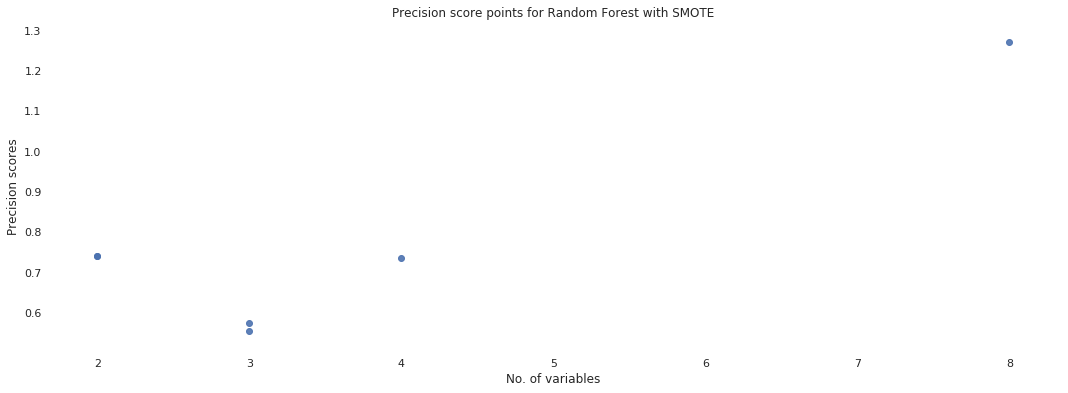

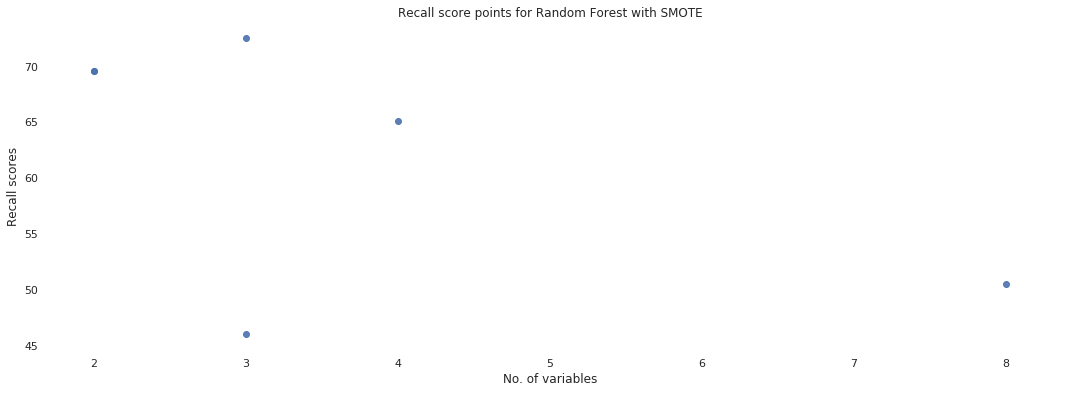

In [1930]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
fig, ax = plt.subplots()
ax.scatter(no_of_variables, precision_summary_table, alpha=0.9)
ax.set_title('Precision score points for Random Forest with SMOTE')
ax.set_xlabel('No. of variables')
ax.set_ylabel('Precision scores')


plt.rcParams['figure.figsize'] = (18.0, 6.0)
fig, ax = plt.subplots()
ax.scatter(no_of_variables, recall_summary_table, alpha=0.9)
ax.set_title('Recall score points for Random Forest with SMOTE')
ax.set_xlabel('No. of variables')
ax.set_ylabel('Recall scores')

## Gradient Boosting classifier

Gradient Boosting is a sequential ensemble classifier. Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. This technique employs the logic in which the subsequent predictors learn from the mistakes of the previous predictors. Therefore, the observations have an unequal probability of appearing in subsequent models and ones with the highest error appear most. (So the observations are not chosen based on the bootstrap process, but based on the error). The predictors can be chosen from a range of models like decision trees, regressors, classifiers, and etc. Since new predictors are learning from mistakes committed by previous predictors, it takes less time/iterations to reach close to actual predictions. However, the stopping criteria must be chosen carefully or it could lead to overfitting on training data. Gradient Boosting will be performed with different cases below.

### Gradient Boosting without sampling

In [1931]:
gb_summary_table = [["MODEL", "SAMPLING", "NO_VARS", "ACC.", "PRE.", "REC.", "FPR.", "ERR.", "TP", "TN", "VARS."]]

recall_summary_table = []
precision_summary_table = []
no_of_variables = []

# Set variables to be participated in the model development.
X = dataset[['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']]
Y = dataset.failure
DEPTH = 8 # Define the max depth to 8 since there are 8 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(gb_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'GB', 'NO')

Fold - 1
-------------  Confusion Matrix  ----------------
[[12369    70]
 [    8     3]]
-------------     Statistics     ----------------
Acc.: 99.370%	 Prec.: 4.110%	 Rec.: 27.270%	 F1: 7.140%	 Err.: 0.630%	 FPR: 0.560	TP: 3	 TN: 12369


Fold - 2
-------------  Confusion Matrix  ----------------
[[12421    18]
 [    9     2]]
-------------     Statistics     ----------------
Acc.: 99.780%	 Prec.: 10.000%	 Rec.: 18.180%	 F1: 12.900%	 Err.: 0.220%	 FPR: 0.140	TP: 2	 TN: 12421


Fold - 3
-------------  Confusion Matrix  ----------------
[[12431     8]
 [   10     1]]
-------------     Statistics     ----------------
Acc.: 99.860%	 Prec.: 11.110%	 Rec.: 9.090%	 F1: 10.000%	 Err.: 0.140%	 FPR: 0.060	TP: 1	 TN: 12431


Fold - 4
-------------  Confusion Matrix  ----------------
[[12438     1]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.900%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.100%	 FPR: 0.010	TP: 0	 TN: 12438


Fold - 5
-------------  Confusion Ma

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
GB,NO,8,99.6441,2.5221,5.4545,0.0028,0.3559,0.6,12404.5,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"


In [1932]:
# Set variables to be participated in the model development.
X = dataset[['attribute2', 'attribute5', 'attribute6']]
Y = dataset.failure
DEPTH = 3 # Define the max depth to 3 since there are only 3 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(gb_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'GB', 'NO')

Fold - 1
-------------  Confusion Matrix  ----------------
[[12425    14]
 [   10     1]]
-------------     Statistics     ----------------
Acc.: 99.810%	 Prec.: 6.670%	 Rec.: 9.090%	 F1: 7.690%	 Err.: 0.190%	 FPR: 0.110	TP: 1	 TN: 12425


Fold - 2
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 3
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 4
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 5
-------------  Confusion Matrix  ----

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
GB,NO,8,99.6441,2.5221,5.4545,0.0028,0.3559,0.6,12404.5,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,NO,3,99.8964,0.6667,0.9091,0.0002,0.1036,0.1,12436.4,"['attribute2', 'attribute5', 'attribute6']"


In [1933]:
# Set variables to be participated in the model development.
X = dataset[['attribute1', 'attribute2', 'attribute4', 'attribute6']]
Y = dataset.failure
DEPTH = 4 # Define the max depth to 4 since there are 4 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(gb_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'GB', 'NO')

Fold - 1
-------------  Confusion Matrix  ----------------
[[12419    20]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.750%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.250%	 FPR: 0.160	TP: 0	 TN: 12419


Fold - 2
-------------  Confusion Matrix  ----------------
[[12438     1]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.900%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.100%	 FPR: 0.010	TP: 0	 TN: 12438


Fold - 3
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 4
-------------  Confusion Matrix  ----------------
[[12424    15]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.790%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.210%	 FPR: 0.120	TP: 0	 TN: 12424


Fold - 5
-------------  Confusion Matrix  ------

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
GB,NO,8,99.6441,2.5221,5.4545,0.0028,0.3559,0.6,12404.5,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,NO,3,99.8964,0.6667,0.9091,0.0002,0.1036,0.1,12436.4,"['attribute2', 'attribute5', 'attribute6']"
GB,NO,4,99.4803,0.0,0.0,0.0043,0.5197,0.0,12384.7,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"


In [1934]:
# Set variables to be participated in the model development.
X = dataset[['attribute2', 'attribute4', 'attribute6']]
Y = dataset.failure
DEPTH = 3 # Define the max depth to 4 since there are only 3 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(gb_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'GB', 'NO')

Fold - 1
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 2
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 3
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 4
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 5
-------------  Confusion Matrix  ------

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
GB,NO,8,99.6441,2.5221,5.4545,0.0028,0.3559,0.6,12404.5,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,NO,3,99.8964,0.6667,0.9091,0.0002,0.1036,0.1,12436.4,"['attribute2', 'attribute5', 'attribute6']"
GB,NO,4,99.4803,0.0,0.0,0.0043,0.5197,0.0,12384.7,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,NO,3,99.8819,0.0,0.0,0.0003,0.1181,0.0,12434.7,"['attribute2', 'attribute4', 'attribute6']"


In [1935]:
## Set variables to be participated in the model development.
X = dataset[['attribute4', 'attribute7']]
Y = dataset.failure
DEPTH = 2 # Define the max depth to 4 since there are only 3 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(gb_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'GB', 'NO')

Fold - 1
-------------  Confusion Matrix  ----------------
[[12423    16]
 [   10     1]]
-------------     Statistics     ----------------
Acc.: 99.790%	 Prec.: 5.880%	 Rec.: 9.090%	 F1: 7.140%	 Err.: 0.210%	 FPR: 0.130	TP: 1	 TN: 12423


Fold - 2
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 3
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 4
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 5
-------------  Confusion Matrix  ----

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
GB,NO,8,99.6441,2.5221,5.4545,0.0028,0.3559,0.6,12404.5,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,NO,3,99.8964,0.6667,0.9091,0.0002,0.1036,0.1,12436.4,"['attribute2', 'attribute5', 'attribute6']"
GB,NO,4,99.4803,0.0,0.0,0.0043,0.5197,0.0,12384.7,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,NO,3,99.8819,0.0,0.0,0.0003,0.1181,0.0,12434.7,"['attribute2', 'attribute4', 'attribute6']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"


In [1936]:
# Set variables to be participated in the model development.
X = dataset[['attribute4', 'attribute7']]
Y = dataset.failure
DEPTH = 2 # Define the max depth to 4 since there are only 3 variable to join in the model development.
ESTIMATORS = 150 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(gb_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'GB', 'NO')

Fold - 1
-------------  Confusion Matrix  ----------------
[[12423    16]
 [   10     1]]
-------------     Statistics     ----------------
Acc.: 99.790%	 Prec.: 5.880%	 Rec.: 9.090%	 F1: 7.140%	 Err.: 0.210%	 FPR: 0.130	TP: 1	 TN: 12423


Fold - 2
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 3
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 4
-------------  Confusion Matrix  ----------------
[[12439     0]
 [   11     0]]
-------------     Statistics     ----------------
Acc.: 99.910%	 Prec.: 0.000%	 Rec.: 0.000%	 F1: nan%	 Err.: 0.090%	 FPR: 0.000	TP: 0	 TN: 12439


Fold - 5
-------------  Confusion Matrix  ----

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
GB,NO,8,99.6441,2.5221,5.4545,0.0028,0.3559,0.6,12404.5,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,NO,3,99.8964,0.6667,0.9091,0.0002,0.1036,0.1,12436.4,"['attribute2', 'attribute5', 'attribute6']"
GB,NO,4,99.4803,0.0,0.0,0.0043,0.5197,0.0,12384.7,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,NO,3,99.8819,0.0,0.0,0.0003,0.1181,0.0,12434.7,"['attribute2', 'attribute4', 'attribute6']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"


With no sampling technique, Gradient Boosting show almost the same model performance as Random Forest without sampling.

### Gradient Boosting with over-sampling

In [1937]:
recall_summary_table = []
precision_summary_table = []
no_of_variables = []

# Set variables to be participated in the model development.
X = dataset[['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']]
Y = dataset.failure
DEPTH = 8 # Define the max depth to 8 since there are 8 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(gb_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'GB', 'OVERSAMPLING')

Fold - 1
-------------  Confusion Matrix  ----------------
[[11779   660]
 [    5     6]]
-------------     Statistics     ----------------
Acc.: 94.660%	 Prec.: 0.900%	 Rec.: 54.550%	 F1: 1.770%	 Err.: 5.340%	 FPR: 5.310	TP: 6	 TN: 11779


Fold - 2
-------------  Confusion Matrix  ----------------
[[11692   747]
 [    5     6]]
-------------     Statistics     ----------------
Acc.: 93.960%	 Prec.: 0.800%	 Rec.: 54.550%	 F1: 1.570%	 Err.: 6.040%	 FPR: 6.010	TP: 6	 TN: 11692


Fold - 3
-------------  Confusion Matrix  ----------------
[[11882   557]
 [    5     6]]
-------------     Statistics     ----------------
Acc.: 95.490%	 Prec.: 1.070%	 Rec.: 54.550%	 F1: 2.090%	 Err.: 4.510%	 FPR: 4.480	TP: 6	 TN: 11882


Fold - 4
-------------  Confusion Matrix  ----------------
[[11907   532]
 [    8     3]]
-------------     Statistics     ----------------
Acc.: 95.660%	 Prec.: 0.560%	 Rec.: 27.270%	 F1: 1.100%	 Err.: 4.340%	 FPR: 4.280	TP: 3	 TN: 11907


Fold - 5
-------------  Confusion Ma

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
GB,NO,8,99.6441,2.5221,5.4545,0.0028,0.3559,0.6,12404.5,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,NO,3,99.8964,0.6667,0.9091,0.0002,0.1036,0.1,12436.4,"['attribute2', 'attribute5', 'attribute6']"
GB,NO,4,99.4803,0.0,0.0,0.0043,0.5197,0.0,12384.7,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,NO,3,99.8819,0.0,0.0,0.0003,0.1181,0.0,12434.7,"['attribute2', 'attribute4', 'attribute6']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,OVERSAMPLING,8,95.2134,0.7726,43.3636,0.0474,4.7866,4.6,11848.9,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"


In [1938]:
# Set variables to be participated in the model development.
X = dataset[['attribute2', 'attribute5', 'attribute6']]
Y = dataset.failure
DEPTH = 3 # Define the max depth to 3 since there are only 3 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(gb_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'GB', 'OVERSAMPLING')

Fold - 1
-------------  Confusion Matrix  ----------------
[[11605   834]
 [    7     4]]
-------------     Statistics     ----------------
Acc.: 93.240%	 Prec.: 0.480%	 Rec.: 36.360%	 F1: 0.940%	 Err.: 6.760%	 FPR: 6.700	TP: 4	 TN: 11605


Fold - 2
-------------  Confusion Matrix  ----------------
[[11272  1167]
 [    8     3]]
-------------     Statistics     ----------------
Acc.: 90.560%	 Prec.: 0.260%	 Rec.: 27.270%	 F1: 0.510%	 Err.: 9.440%	 FPR: 9.380	TP: 3	 TN: 11272


Fold - 3
-------------  Confusion Matrix  ----------------
[[11289  1150]
 [    5     6]]
-------------     Statistics     ----------------
Acc.: 90.720%	 Prec.: 0.520%	 Rec.: 54.550%	 F1: 1.030%	 Err.: 9.280%	 FPR: 9.250	TP: 6	 TN: 11289


Fold - 4
-------------  Confusion Matrix  ----------------
[[11538   901]
 [    6     5]]
-------------     Statistics     ----------------
Acc.: 92.710%	 Prec.: 0.550%	 Rec.: 45.450%	 F1: 1.090%	 Err.: 7.290%	 FPR: 7.240	TP: 5	 TN: 11538


Fold - 5
-------------  Confusion Ma

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
GB,NO,8,99.6441,2.5221,5.4545,0.0028,0.3559,0.6,12404.5,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,NO,3,99.8964,0.6667,0.9091,0.0002,0.1036,0.1,12436.4,"['attribute2', 'attribute5', 'attribute6']"
GB,NO,4,99.4803,0.0,0.0,0.0043,0.5197,0.0,12384.7,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,NO,3,99.8819,0.0,0.0,0.0003,0.1181,0.0,12434.7,"['attribute2', 'attribute4', 'attribute6']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,OVERSAMPLING,8,95.2134,0.7726,43.3636,0.0474,4.7866,4.6,11848.9,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,OVERSAMPLING,3,92.6206,0.4734,37.5455,0.0733,7.3794,4.0,11526.7,"['attribute2', 'attribute5', 'attribute6']"


In [1939]:
# Set variables to be participated in the model development.
X = dataset[['attribute1', 'attribute2', 'attribute4', 'attribute6']]
Y = dataset.failure
DEPTH = 4 # Define the max depth to 4 since there are 4 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(gb_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'GB', 'OVERSAMPLING')

Fold - 1
-------------  Confusion Matrix  ----------------
[[11474   965]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 92.220%	 Prec.: 0.720%	 Rec.: 63.640%	 F1: 1.420%	 Err.: 7.780%	 FPR: 7.760	TP: 7	 TN: 11474


Fold - 2
-------------  Confusion Matrix  ----------------
[[11184  1255]
 [    2     9]]
-------------     Statistics     ----------------
Acc.: 89.900%	 Prec.: 0.710%	 Rec.: 81.820%	 F1: 1.410%	 Err.: 10.100%	 FPR: 10.090	TP: 9	 TN: 11184


Fold - 3
-------------  Confusion Matrix  ----------------
[[11625   814]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 93.430%	 Prec.: 0.850%	 Rec.: 63.640%	 F1: 1.680%	 Err.: 6.570%	 FPR: 6.540	TP: 7	 TN: 11625


Fold - 4
-------------  Confusion Matrix  ----------------
[[11720   719]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 94.190%	 Prec.: 0.960%	 Rec.: 63.640%	 F1: 1.900%	 Err.: 5.810%	 FPR: 5.780	TP: 7	 TN: 11720


Fold - 5
-------------  Confusion 

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
GB,NO,8,99.6441,2.5221,5.4545,0.0028,0.3559,0.6,12404.5,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,NO,3,99.8964,0.6667,0.9091,0.0002,0.1036,0.1,12436.4,"['attribute2', 'attribute5', 'attribute6']"
GB,NO,4,99.4803,0.0,0.0,0.0043,0.5197,0.0,12384.7,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,NO,3,99.8819,0.0,0.0,0.0003,0.1181,0.0,12434.7,"['attribute2', 'attribute4', 'attribute6']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,OVERSAMPLING,8,95.2134,0.7726,43.3636,0.0474,4.7866,4.6,11848.9,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,OVERSAMPLING,3,92.6206,0.4734,37.5455,0.0733,7.3794,4.0,11526.7,"['attribute2', 'attribute5', 'attribute6']"
GB,OVERSAMPLING,4,93.5218,0.8653,64.0909,0.0645,6.4782,6.8,11636.1,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"


In [1940]:
# Set variables to be participated in the model development.
X = dataset[['attribute2', 'attribute4', 'attribute6']]
Y = dataset.failure
DEPTH = 3 # Define the max depth to 3 since there are only 3 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(gb_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'GB', 'OVERSAMPLING')

Fold - 1
-------------  Confusion Matrix  ----------------
[[11297  1142]
 [    3     8]]
-------------     Statistics     ----------------
Acc.: 90.800%	 Prec.: 0.700%	 Rec.: 72.730%	 F1: 1.380%	 Err.: 9.200%	 FPR: 9.180	TP: 8	 TN: 11297


Fold - 2
-------------  Confusion Matrix  ----------------
[[11544   895]
 [    2     9]]
-------------     Statistics     ----------------
Acc.: 92.800%	 Prec.: 1.000%	 Rec.: 81.820%	 F1: 1.970%	 Err.: 7.200%	 FPR: 7.200	TP: 9	 TN: 11544


Fold - 3
-------------  Confusion Matrix  ----------------
[[11585   854]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 93.110%	 Prec.: 0.810%	 Rec.: 63.640%	 F1: 1.610%	 Err.: 6.890%	 FPR: 6.870	TP: 7	 TN: 11585


Fold - 4
-------------  Confusion Matrix  ----------------
[[11624   815]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 93.420%	 Prec.: 0.850%	 Rec.: 63.640%	 F1: 1.680%	 Err.: 6.580%	 FPR: 6.550	TP: 7	 TN: 11624


Fold - 5
-------------  Confusion Ma

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
GB,NO,8,99.6441,2.5221,5.4545,0.0028,0.3559,0.6,12404.5,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,NO,3,99.8964,0.6667,0.9091,0.0002,0.1036,0.1,12436.4,"['attribute2', 'attribute5', 'attribute6']"
GB,NO,4,99.4803,0.0,0.0,0.0043,0.5197,0.0,12384.7,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,NO,3,99.8819,0.0,0.0,0.0003,0.1181,0.0,12434.7,"['attribute2', 'attribute4', 'attribute6']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,OVERSAMPLING,8,95.2134,0.7726,43.3636,0.0474,4.7866,4.6,11848.9,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,OVERSAMPLING,3,92.6206,0.4734,37.5455,0.0733,7.3794,4.0,11526.7,"['attribute2', 'attribute5', 'attribute6']"
GB,OVERSAMPLING,4,93.5218,0.8653,64.0909,0.0645,6.4782,6.8,11636.1,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,OVERSAMPLING,3,93.227,0.8576,67.9091,0.0675,6.773,7.2,11599.0,"['attribute2', 'attribute4', 'attribute6']"


In [1941]:
# Set variables to be participated in the model development.
X = dataset[['attribute4', 'attribute7']]
Y = dataset.failure
DEPTH = 2 # Define the max depth to 2 since there are only 2 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(gb_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'GB', 'OVERSAMPLING')

Fold - 1
-------------  Confusion Matrix  ----------------
[[11113  1326]
 [    2     9]]
-------------     Statistics     ----------------
Acc.: 89.330%	 Prec.: 0.670%	 Rec.: 81.820%	 F1: 1.340%	 Err.: 10.670%	 FPR: 10.660	TP: 9	 TN: 11113


Fold - 2
-------------  Confusion Matrix  ----------------
[[11493   946]
 [    0    11]]
-------------     Statistics     ----------------
Acc.: 92.400%	 Prec.: 1.150%	 Rec.: 100.000%	 F1: 2.270%	 Err.: 7.600%	 FPR: 7.610	TP: 11	 TN: 11493


Fold - 3
-------------  Confusion Matrix  ----------------
[[11507   932]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 92.480%	 Prec.: 0.750%	 Rec.: 63.640%	 F1: 1.470%	 Err.: 7.520%	 FPR: 7.490	TP: 7	 TN: 11507


Fold - 4
-------------  Confusion Matrix  ----------------
[[11516   923]
 [    5     6]]
-------------     Statistics     ----------------
Acc.: 92.550%	 Prec.: 0.650%	 Rec.: 54.550%	 F1: 1.280%	 Err.: 7.450%	 FPR: 7.420	TP: 6	 TN: 11516


Fold - 5
-------------  Confusio

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
GB,NO,8,99.6441,2.5221,5.4545,0.0028,0.3559,0.6,12404.5,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,NO,3,99.8964,0.6667,0.9091,0.0002,0.1036,0.1,12436.4,"['attribute2', 'attribute5', 'attribute6']"
GB,NO,4,99.4803,0.0,0.0,0.0043,0.5197,0.0,12384.7,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,NO,3,99.8819,0.0,0.0,0.0003,0.1181,0.0,12434.7,"['attribute2', 'attribute4', 'attribute6']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,OVERSAMPLING,8,95.2134,0.7726,43.3636,0.0474,4.7866,4.6,11848.9,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,OVERSAMPLING,3,92.6206,0.4734,37.5455,0.0733,7.3794,4.0,11526.7,"['attribute2', 'attribute5', 'attribute6']"
GB,OVERSAMPLING,4,93.5218,0.8653,64.0909,0.0645,6.4782,6.8,11636.1,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,OVERSAMPLING,3,93.227,0.8576,67.9091,0.0675,6.773,7.2,11599.0,"['attribute2', 'attribute4', 'attribute6']"


In [1942]:
# Set variables to be participated in the model development.
X = dataset[['attribute4', 'attribute7']]
Y = dataset.failure
DEPTH = 2 # Define the max depth to 2 since there are only 2 variable to join in the model development.
ESTIMATORS = 150 # No. of estimators changed to 150 from 100.
NEIGHBORS = 0
run_model(gb_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'GB', 'OVERSAMPLING')

Fold - 1
-------------  Confusion Matrix  ----------------
[[11113  1326]
 [    2     9]]
-------------     Statistics     ----------------
Acc.: 89.330%	 Prec.: 0.670%	 Rec.: 81.820%	 F1: 1.340%	 Err.: 10.670%	 FPR: 10.660	TP: 9	 TN: 11113


Fold - 2
-------------  Confusion Matrix  ----------------
[[11493   946]
 [    0    11]]
-------------     Statistics     ----------------
Acc.: 92.400%	 Prec.: 1.150%	 Rec.: 100.000%	 F1: 2.270%	 Err.: 7.600%	 FPR: 7.610	TP: 11	 TN: 11493


Fold - 3
-------------  Confusion Matrix  ----------------
[[11507   932]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 92.480%	 Prec.: 0.750%	 Rec.: 63.640%	 F1: 1.470%	 Err.: 7.520%	 FPR: 7.490	TP: 7	 TN: 11507


Fold - 4
-------------  Confusion Matrix  ----------------
[[11516   923]
 [    5     6]]
-------------     Statistics     ----------------
Acc.: 92.550%	 Prec.: 0.650%	 Rec.: 54.550%	 F1: 1.280%	 Err.: 7.450%	 FPR: 7.420	TP: 6	 TN: 11516


Fold - 5
-------------  Confusio

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
GB,NO,8,99.6441,2.5221,5.4545,0.0028,0.3559,0.6,12404.5,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,NO,3,99.8964,0.6667,0.9091,0.0002,0.1036,0.1,12436.4,"['attribute2', 'attribute5', 'attribute6']"
GB,NO,4,99.4803,0.0,0.0,0.0043,0.5197,0.0,12384.7,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,NO,3,99.8819,0.0,0.0,0.0003,0.1181,0.0,12434.7,"['attribute2', 'attribute4', 'attribute6']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,OVERSAMPLING,8,95.2134,0.7726,43.3636,0.0474,4.7866,4.6,11848.9,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,OVERSAMPLING,3,92.6206,0.4734,37.5455,0.0733,7.3794,4.0,11526.7,"['attribute2', 'attribute5', 'attribute6']"
GB,OVERSAMPLING,4,93.5218,0.8653,64.0909,0.0645,6.4782,6.8,11636.1,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,OVERSAMPLING,3,93.227,0.8576,67.9091,0.0675,6.773,7.2,11599.0,"['attribute2', 'attribute4', 'attribute6']"


Text(0, 0.5, 'Recall scores')

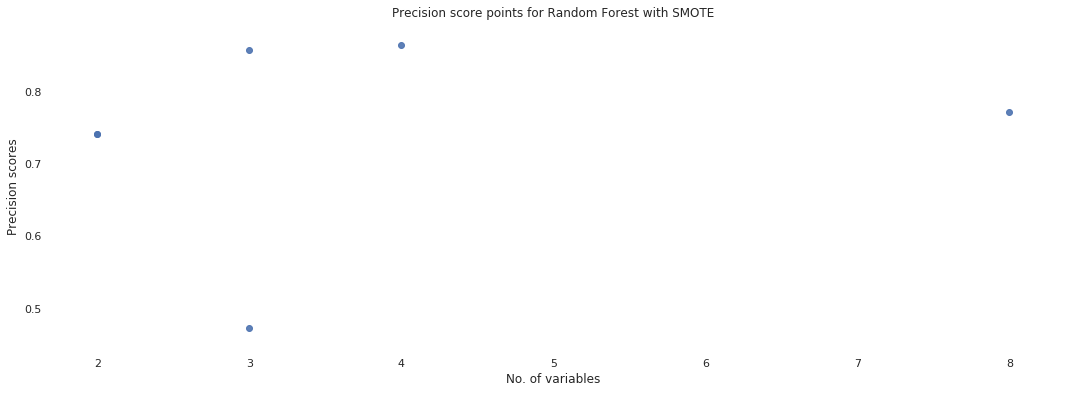

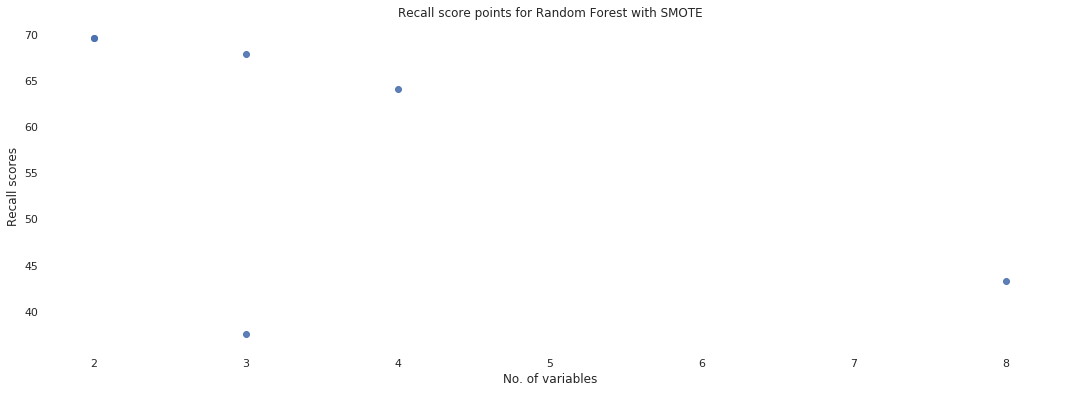

In [1943]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
fig, ax = plt.subplots()
ax.scatter(no_of_variables, precision_summary_table, alpha=0.9)
ax.set_title('Precision score points for Random Forest with SMOTE')
ax.set_xlabel('No. of variables')
ax.set_ylabel('Precision scores')


plt.rcParams['figure.figsize'] = (18.0, 6.0)
fig, ax = plt.subplots()
ax.scatter(no_of_variables, recall_summary_table, alpha=0.9)
ax.set_title('Recall score points for Random Forest with SMOTE')
ax.set_xlabel('No. of variables')
ax.set_ylabel('Recall scores')

The model performance has improved with over-sampling applied to Graident Boosting. 

### Gradient Boosting with SMOTE

In [1944]:
recall_summary_table = []
precision_summary_table = []
no_of_variables = []

# Set variables to be participated in the model development.
X = dataset[['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']]
Y = dataset.failure
DEPTH = 8 # Define the max depth to 8 since there are 8 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 2
run_model(gb_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'GB', 'SMOTE')

Fold - 1
-------------  Confusion Matrix  ----------------
[[11914   525]
 [    5     6]]
-------------     Statistics     ----------------
Acc.: 95.740%	 Prec.: 1.130%	 Rec.: 54.550%	 F1: 2.210%	 Err.: 4.260%	 FPR: 4.220	TP: 6	 TN: 11914


Fold - 2
-------------  Confusion Matrix  ----------------
[[11986   453]
 [    6     5]]
-------------     Statistics     ----------------
Acc.: 96.310%	 Prec.: 1.090%	 Rec.: 45.450%	 F1: 2.130%	 Err.: 3.690%	 FPR: 3.640	TP: 5	 TN: 11986


Fold - 3
-------------  Confusion Matrix  ----------------
[[12105   334]
 [    3     8]]
-------------     Statistics     ----------------
Acc.: 97.290%	 Prec.: 2.340%	 Rec.: 72.730%	 F1: 4.530%	 Err.: 2.710%	 FPR: 2.690	TP: 8	 TN: 12105


Fold - 4
-------------  Confusion Matrix  ----------------
[[12228   211]
 [    6     5]]
-------------     Statistics     ----------------
Acc.: 98.260%	 Prec.: 2.310%	 Rec.: 45.450%	 F1: 4.410%	 Err.: 1.740%	 FPR: 1.700	TP: 5	 TN: 12228


Fold - 5
-------------  Confusion Ma

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
GB,NO,8,99.6441,2.5221,5.4545,0.0028,0.3559,0.6,12404.5,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,NO,3,99.8964,0.6667,0.9091,0.0002,0.1036,0.1,12436.4,"['attribute2', 'attribute5', 'attribute6']"
GB,NO,4,99.4803,0.0,0.0,0.0043,0.5197,0.0,12384.7,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,NO,3,99.8819,0.0,0.0,0.0003,0.1181,0.0,12434.7,"['attribute2', 'attribute4', 'attribute6']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,OVERSAMPLING,8,95.2134,0.7726,43.3636,0.0474,4.7866,4.6,11848.9,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,OVERSAMPLING,3,92.6206,0.4734,37.5455,0.0733,7.3794,4.0,11526.7,"['attribute2', 'attribute5', 'attribute6']"
GB,OVERSAMPLING,4,93.5218,0.8653,64.0909,0.0645,6.4782,6.8,11636.1,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,OVERSAMPLING,3,93.227,0.8576,67.9091,0.0675,6.773,7.2,11599.0,"['attribute2', 'attribute4', 'attribute6']"


In [1945]:
# Set variables to be participated in the model development.
X = dataset[['attribute2', 'attribute5', 'attribute6']]
Y = dataset.failure
DEPTH = 3 # Define the max depth to 3 since there are only 3 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 2
run_model(gb_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'GB', 'SMOTE')

Fold - 1
-------------  Confusion Matrix  ----------------
[[11658   781]
 [    5     6]]
-------------     Statistics     ----------------
Acc.: 93.690%	 Prec.: 0.760%	 Rec.: 54.550%	 F1: 1.500%	 Err.: 6.310%	 FPR: 6.280	TP: 6	 TN: 11658


Fold - 2
-------------  Confusion Matrix  ----------------
[[11035  1404]
 [    8     3]]
-------------     Statistics     ----------------
Acc.: 88.660%	 Prec.: 0.210%	 Rec.: 27.270%	 F1: 0.420%	 Err.: 11.340%	 FPR: 11.290	TP: 3	 TN: 11035


Fold - 3
-------------  Confusion Matrix  ----------------
[[11777   662]
 [    5     6]]
-------------     Statistics     ----------------
Acc.: 94.640%	 Prec.: 0.900%	 Rec.: 54.550%	 F1: 1.770%	 Err.: 5.360%	 FPR: 5.320	TP: 6	 TN: 11777


Fold - 4
-------------  Confusion Matrix  ----------------
[[11772   667]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 94.610%	 Prec.: 1.040%	 Rec.: 63.640%	 F1: 2.040%	 Err.: 5.390%	 FPR: 5.360	TP: 7	 TN: 11772


Fold - 5
-------------  Confusion 

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
GB,NO,8,99.6441,2.5221,5.4545,0.0028,0.3559,0.6,12404.5,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,NO,3,99.8964,0.6667,0.9091,0.0002,0.1036,0.1,12436.4,"['attribute2', 'attribute5', 'attribute6']"
GB,NO,4,99.4803,0.0,0.0,0.0043,0.5197,0.0,12384.7,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,NO,3,99.8819,0.0,0.0,0.0003,0.1181,0.0,12434.7,"['attribute2', 'attribute4', 'attribute6']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,OVERSAMPLING,8,95.2134,0.7726,43.3636,0.0474,4.7866,4.6,11848.9,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,OVERSAMPLING,3,92.6206,0.4734,37.5455,0.0733,7.3794,4.0,11526.7,"['attribute2', 'attribute5', 'attribute6']"
GB,OVERSAMPLING,4,93.5218,0.8653,64.0909,0.0645,6.4782,6.8,11636.1,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,OVERSAMPLING,3,93.227,0.8576,67.9091,0.0675,6.773,7.2,11599.0,"['attribute2', 'attribute4', 'attribute6']"


In [1946]:
# Set variables to be participated in the model development.
X = dataset[['attribute1', 'attribute2', 'attribute4', 'attribute6']]
Y = dataset.failure
DEPTH = 4 # Define the max depth to 4 since there are 4 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 2
run_model(gb_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'GB', 'SMOTE')

Fold - 1
-------------  Confusion Matrix  ----------------
[[11217  1222]
 [    2     9]]
-------------     Statistics     ----------------
Acc.: 90.170%	 Prec.: 0.730%	 Rec.: 81.820%	 F1: 1.450%	 Err.: 9.830%	 FPR: 9.820	TP: 9	 TN: 11217


Fold - 2
-------------  Confusion Matrix  ----------------
[[11559   880]
 [    3     8]]
-------------     Statistics     ----------------
Acc.: 92.910%	 Prec.: 0.900%	 Rec.: 72.730%	 F1: 1.780%	 Err.: 7.090%	 FPR: 7.070	TP: 8	 TN: 11559


Fold - 3
-------------  Confusion Matrix  ----------------
[[11537   902]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 92.720%	 Prec.: 0.770%	 Rec.: 63.640%	 F1: 1.520%	 Err.: 7.280%	 FPR: 7.250	TP: 7	 TN: 11537


Fold - 4
-------------  Confusion Matrix  ----------------
[[11500   939]
 [    5     6]]
-------------     Statistics     ----------------
Acc.: 92.420%	 Prec.: 0.630%	 Rec.: 54.550%	 F1: 1.260%	 Err.: 7.580%	 FPR: 7.550	TP: 6	 TN: 11500


Fold - 5
-------------  Confusion Ma

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
GB,NO,8,99.6441,2.5221,5.4545,0.0028,0.3559,0.6,12404.5,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,NO,3,99.8964,0.6667,0.9091,0.0002,0.1036,0.1,12436.4,"['attribute2', 'attribute5', 'attribute6']"
GB,NO,4,99.4803,0.0,0.0,0.0043,0.5197,0.0,12384.7,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,NO,3,99.8819,0.0,0.0,0.0003,0.1181,0.0,12434.7,"['attribute2', 'attribute4', 'attribute6']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,OVERSAMPLING,8,95.2134,0.7726,43.3636,0.0474,4.7866,4.6,11848.9,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,OVERSAMPLING,3,92.6206,0.4734,37.5455,0.0733,7.3794,4.0,11526.7,"['attribute2', 'attribute5', 'attribute6']"
GB,OVERSAMPLING,4,93.5218,0.8653,64.0909,0.0645,6.4782,6.8,11636.1,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,OVERSAMPLING,3,93.227,0.8576,67.9091,0.0675,6.773,7.2,11599.0,"['attribute2', 'attribute4', 'attribute6']"


In [1947]:
# Set variables to be participated in the model development.
X = dataset[['attribute2', 'attribute4', 'attribute6']]
Y = dataset.failure
DEPTH = 3 # Define the max depth to 3 since there are only 3 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 2
run_model(gb_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'GB', 'SMOTE')

Fold - 1
-------------  Confusion Matrix  ----------------
[[11159  1280]
 [    2     9]]
-------------     Statistics     ----------------
Acc.: 89.700%	 Prec.: 0.700%	 Rec.: 81.820%	 F1: 1.380%	 Err.: 10.300%	 FPR: 10.290	TP: 9	 TN: 11159


Fold - 2
-------------  Confusion Matrix  ----------------
[[11133  1306]
 [    1    10]]
-------------     Statistics     ----------------
Acc.: 89.500%	 Prec.: 0.760%	 Rec.: 90.910%	 F1: 1.510%	 Err.: 10.500%	 FPR: 10.500	TP: 10	 TN: 11133


Fold - 3
-------------  Confusion Matrix  ----------------
[[11137  1302]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 89.510%	 Prec.: 0.530%	 Rec.: 63.640%	 F1: 1.060%	 Err.: 10.490%	 FPR: 10.470	TP: 7	 TN: 11137


Fold - 4
-------------  Confusion Matrix  ----------------
[[11109  1330]
 [    3     8]]
-------------     Statistics     ----------------
Acc.: 89.290%	 Prec.: 0.600%	 Rec.: 72.730%	 F1: 1.190%	 Err.: 10.710%	 FPR: 10.690	TP: 8	 TN: 11109


Fold - 5
-------------  Con

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
GB,NO,8,99.6441,2.5221,5.4545,0.0028,0.3559,0.6,12404.5,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,NO,3,99.8964,0.6667,0.9091,0.0002,0.1036,0.1,12436.4,"['attribute2', 'attribute5', 'attribute6']"
GB,NO,4,99.4803,0.0,0.0,0.0043,0.5197,0.0,12384.7,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,NO,3,99.8819,0.0,0.0,0.0003,0.1181,0.0,12434.7,"['attribute2', 'attribute4', 'attribute6']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,OVERSAMPLING,8,95.2134,0.7726,43.3636,0.0474,4.7866,4.6,11848.9,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,OVERSAMPLING,3,92.6206,0.4734,37.5455,0.0733,7.3794,4.0,11526.7,"['attribute2', 'attribute5', 'attribute6']"
GB,OVERSAMPLING,4,93.5218,0.8653,64.0909,0.0645,6.4782,6.8,11636.1,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,OVERSAMPLING,3,93.227,0.8576,67.9091,0.0675,6.773,7.2,11599.0,"['attribute2', 'attribute4', 'attribute6']"


In [1948]:
# Set variables to be participated in the model development.
X = dataset[['attribute4', 'attribute7']]
Y = dataset.failure
DEPTH = 3 # Define the max depth to 2 since there are only 2 variable to join in the model development.
ESTIMATORS = 100 # No. of estimators changed to 150.
NEIGHBORS = 2
run_model(gb_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'GB', 'SMOTE')

Fold - 1
-------------  Confusion Matrix  ----------------
[[11113  1326]
 [    2     9]]
-------------     Statistics     ----------------
Acc.: 89.330%	 Prec.: 0.670%	 Rec.: 81.820%	 F1: 1.340%	 Err.: 10.670%	 FPR: 10.660	TP: 9	 TN: 11113


Fold - 2
-------------  Confusion Matrix  ----------------
[[11821   618]
 [    0    11]]
-------------     Statistics     ----------------
Acc.: 95.040%	 Prec.: 1.750%	 Rec.: 100.000%	 F1: 3.440%	 Err.: 4.960%	 FPR: 4.970	TP: 11	 TN: 11821


Fold - 3
-------------  Confusion Matrix  ----------------
[[11507   932]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 92.480%	 Prec.: 0.750%	 Rec.: 63.640%	 F1: 1.470%	 Err.: 7.520%	 FPR: 7.490	TP: 7	 TN: 11507


Fold - 4
-------------  Confusion Matrix  ----------------
[[11516   923]
 [    5     6]]
-------------     Statistics     ----------------
Acc.: 92.550%	 Prec.: 0.650%	 Rec.: 54.550%	 F1: 1.280%	 Err.: 7.450%	 FPR: 7.420	TP: 6	 TN: 11516


Fold - 5
-------------  Confusio

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
GB,NO,8,99.6441,2.5221,5.4545,0.0028,0.3559,0.6,12404.5,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,NO,3,99.8964,0.6667,0.9091,0.0002,0.1036,0.1,12436.4,"['attribute2', 'attribute5', 'attribute6']"
GB,NO,4,99.4803,0.0,0.0,0.0043,0.5197,0.0,12384.7,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,NO,3,99.8819,0.0,0.0,0.0003,0.1181,0.0,12434.7,"['attribute2', 'attribute4', 'attribute6']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,OVERSAMPLING,8,95.2134,0.7726,43.3636,0.0474,4.7866,4.6,11848.9,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,OVERSAMPLING,3,92.6206,0.4734,37.5455,0.0733,7.3794,4.0,11526.7,"['attribute2', 'attribute5', 'attribute6']"
GB,OVERSAMPLING,4,93.5218,0.8653,64.0909,0.0645,6.4782,6.8,11636.1,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,OVERSAMPLING,3,93.227,0.8576,67.9091,0.0675,6.773,7.2,11599.0,"['attribute2', 'attribute4', 'attribute6']"


In [1949]:
# Set variables to be participated in the model development.
X = dataset[['attribute4', 'attribute7']]
Y = dataset.failure
DEPTH = 3 # Define the max depth to 2 since there are only 2 variable to join in the model development.
ESTIMATORS = 150 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 2
run_model(gb_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'GB', 'SMOTE')

Fold - 1
-------------  Confusion Matrix  ----------------
[[11113  1326]
 [    2     9]]
-------------     Statistics     ----------------
Acc.: 89.330%	 Prec.: 0.670%	 Rec.: 81.820%	 F1: 1.340%	 Err.: 10.670%	 FPR: 10.660	TP: 9	 TN: 11113


Fold - 2
-------------  Confusion Matrix  ----------------
[[11821   618]
 [    0    11]]
-------------     Statistics     ----------------
Acc.: 95.040%	 Prec.: 1.750%	 Rec.: 100.000%	 F1: 3.440%	 Err.: 4.960%	 FPR: 4.970	TP: 11	 TN: 11821


Fold - 3
-------------  Confusion Matrix  ----------------
[[11507   932]
 [    4     7]]
-------------     Statistics     ----------------
Acc.: 92.480%	 Prec.: 0.750%	 Rec.: 63.640%	 F1: 1.470%	 Err.: 7.520%	 FPR: 7.490	TP: 7	 TN: 11507


Fold - 4
-------------  Confusion Matrix  ----------------
[[11516   923]
 [    5     6]]
-------------     Statistics     ----------------
Acc.: 92.550%	 Prec.: 0.650%	 Rec.: 54.550%	 F1: 1.280%	 Err.: 7.450%	 FPR: 7.420	TP: 6	 TN: 11516


Fold - 5
-------------  Confusio

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
GB,NO,8,99.6441,2.5221,5.4545,0.0028,0.3559,0.6,12404.5,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,NO,3,99.8964,0.6667,0.9091,0.0002,0.1036,0.1,12436.4,"['attribute2', 'attribute5', 'attribute6']"
GB,NO,4,99.4803,0.0,0.0,0.0043,0.5197,0.0,12384.7,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,NO,3,99.8819,0.0,0.0,0.0003,0.1181,0.0,12434.7,"['attribute2', 'attribute4', 'attribute6']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,OVERSAMPLING,8,95.2134,0.7726,43.3636,0.0474,4.7866,4.6,11848.9,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,OVERSAMPLING,3,92.6206,0.4734,37.5455,0.0733,7.3794,4.0,11526.7,"['attribute2', 'attribute5', 'attribute6']"
GB,OVERSAMPLING,4,93.5218,0.8653,64.0909,0.0645,6.4782,6.8,11636.1,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,OVERSAMPLING,3,93.227,0.8576,67.9091,0.0675,6.773,7.2,11599.0,"['attribute2', 'attribute4', 'attribute6']"


Text(0, 0.5, 'Recall scores')

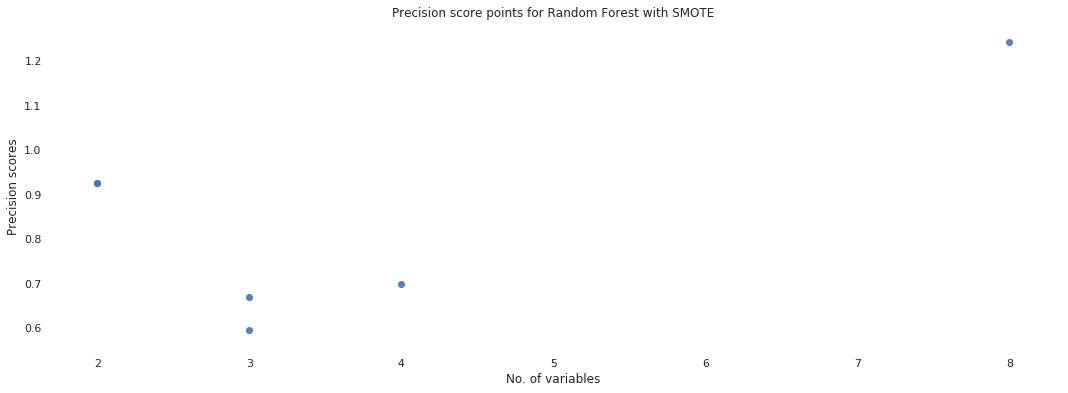

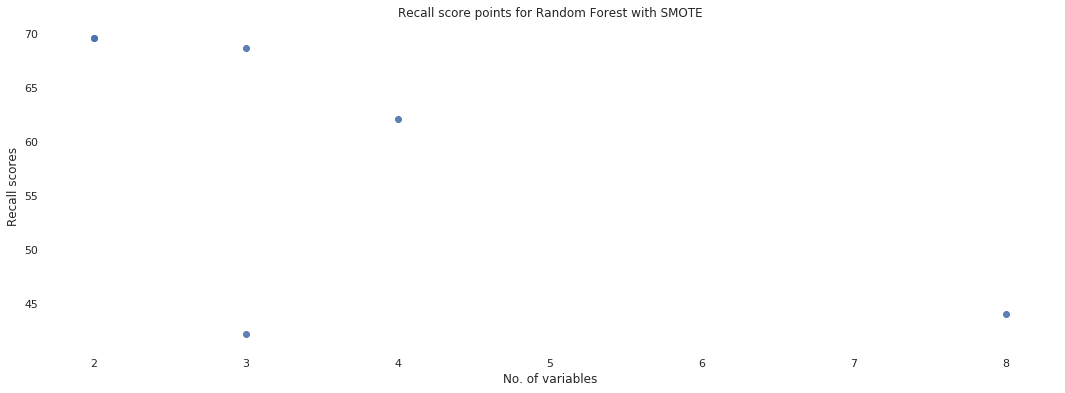

In [1950]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
fig, ax = plt.subplots()
ax.scatter(no_of_variables, precision_summary_table, alpha=0.9)
ax.set_title('Precision score points for Random Forest with SMOTE')
ax.set_xlabel('No. of variables')
ax.set_ylabel('Precision scores')


plt.rcParams['figure.figsize'] = (18.0, 6.0)
fig, ax = plt.subplots()
ax.scatter(no_of_variables, recall_summary_table, alpha=0.9)
ax.set_title('Recall score points for Random Forest with SMOTE')
ax.set_xlabel('No. of variables')
ax.set_ylabel('Recall scores')

Gradient Boosting with SMOTE shows about the same model performance as was done with over-sampling.

## Ensemble of Independent classifers

Three following three different independent classifiers are used to implement an ensemble of classifiers. 
- Random Forest
- AdaBoost
- Gradient Boost

More votes from the ensembled independent classifiers will decide which group the data belong to. The Mode development will follow the same precedures as the previous model developments done with Random Forest and Gradient Boost. The purpose of an ensemble of independent classifier is another way to measure the model performance with a different model development environment. While random forest is a bagging method, AdaBoost and Gradient Boost are boosting methods while Random Forest is a bagging method. The similarity betwen AdaBoost and Gradient Boost is that both of them use a set of weak learners. They try to boost many weak learners into a strong learner. The strong learner is additive by the weak learners. 

Gradient boosting generates learners during the learning process. It build a first learner to predict the values or labels of samples, and calculate the loss which is the difference between the outcome of the first learner and the real value. It will build a second learner to predict the loss after the first step. The step continues to learn the third, forth, and so on, until certain thresholds are fulfilled.

Adaboost requires users specify a set of weak learners. Alternatively, it will randomly generate a set of weak learner before the real learning process. It will learn the weights of how to add these learners to be a strong learner. The weight of each learner is learned by whether it predicts a sample correctly or not. If a learner is mispredict a sample, the weight of the learner is reduced a bit. It will repeat such process until converge.

### Ensemble of independent classifiers without sampling.

In [1951]:
en_summary_table = [["MODEL", "SAMPLING", "NO_VARS", "ACC.", "PRE.", "REC.", "FPR", "ERR.", "TP", "TN", "VARS."]]

recall_summary_table = []
precision_summary_table = []
no_of_variables = []

# Set variables to be participated in the model development.
X = dataset[['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']]
Y = dataset.failure
DEPTH = 8 # Define the max depth to 8 since there are 8 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(en_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'EN', 'NO')

KeyboardInterrupt: 

In [ ]:
# Set variables to be participated in the model development.
X = dataset[['attribute2', 'attribute5', 'attribute6']]
Y = dataset.failure
DEPTH = 3 # Define the max depth to 3 since there are only 3 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(en_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'EN', 'NO')

In [ ]:
# Set variables to be participated in the model development.
X = dataset[['attribute1', 'attribute2', 'attribute4', 'attribute6']]
Y = dataset.failure
DEPTH = 4 # Define the max depth to 4 since there are 4 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(en_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'EN', 'NO')

In [ ]:
# Set variables to be participated in the model development.
X = dataset[['attribute2', 'attribute4', 'attribute6']]
Y = dataset.failure
DEPTH = 3 # Define the max depth to 3 since there are only 3 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(en_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'EN', 'NO')

In [ ]:
## Set variables to be participated in the model development.
X = dataset[['attribute4', 'attribute7']]
Y = dataset.failure
DEPTH = 2 # Define the max depth to 2 since there are only 2 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(en_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'EN', 'NO')

In [ ]:
# Set variables to be participated in the model development.
X = dataset[['attribute4', 'attribute7']]
Y = dataset.failure
DEPTH = 2 # Define the max depth to  since there are only 2 variable to join in the model development.
ESTIMATORS = 150 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(en_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'EN', 'NO')

### Ensemble of independent classifiers with over-sampling.

In [ ]:
recall_summary_table = []
precision_summary_table = []
no_of_variables = []

# Set variables to be participated in the model development.
X = dataset[['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']]
Y = dataset.failure
DEPTH = 8 # Define the max depth to 8 since there are 8 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(en_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'EN', 'OVERSAMPLING')

In [ ]:
# Set variables to be participated in the model development.
X = dataset[['attribute2', 'attribute5', 'attribute6']]
Y = dataset.failure
DEPTH = 3 # Define the max depth to 3 since there are only 3 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(en_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'EN', 'OVERSAMPLING')

In [ ]:
# Set variables to be participated in the model development.
X = dataset[['attribute1', 'attribute2', 'attribute4', 'attribute6']]
Y = dataset.failure
DEPTH = 4 # Define the max depth to 4 since there are 4 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(en_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'EN', 'OVERSAMPLING')

In [ ]:
# Set variables to be participated in the model development.
X = dataset[['attribute2', 'attribute4', 'attribute6']]
Y = dataset.failure
DEPTH = 3 # Define the max depth to 3 since there are only 3 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(en_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'EN', 'OVERSAMPLING')

In [ ]:
## Set variables to be participated in the model development.
X = dataset[['attribute4', 'attribute7']]
Y = dataset.failure
DEPTH = 2 # Define the max depth to 2 since there are only 2 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(en_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'EN', 'OVERSAMPLING')

In [ ]:
# Set variables to be participated in the model development.
X = dataset[['attribute4', 'attribute7']]
Y = dataset.failure
DEPTH = 2 # Define the max depth to 2 since there are only 2 variable to join in the model development.
ESTIMATORS = 150 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 0
run_model(en_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'EN', 'OVERSAMPLING')

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
fig, ax = plt.subplots()
ax.scatter(no_of_variables, precision_summary_table, alpha=0.9)
ax.set_title('Precision score points for Random Forest with SMOTE')
ax.set_xlabel('No. of variables')
ax.set_ylabel('Precision scores')


plt.rcParams['figure.figsize'] = (18.0, 6.0)
fig, ax = plt.subplots()
ax.scatter(no_of_variables, recall_summary_table, alpha=0.9)
ax.set_title('Recall score points for Random Forest with SMOTE')
ax.set_xlabel('No. of variables')
ax.set_ylabel('Recall scores')

### Ensemble of independent classifiers with SMOTE

In [ ]:
recall_summary_table = []
precision_summary_table = []
no_of_variables = []

# Set variables to be participated in the model development.
X = dataset[['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']]
Y = dataset.failure
DEPTH = 8 # Define the max depth to 8 since there are 8 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 2
run_model(en_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'EN', 'SMOTE')

In [ ]:
# Set variables to be participated in the model development.
X = dataset[['attribute2', 'attribute5', 'attribute6']]
Y = dataset.failure
DEPTH = 3 # Define the max depth to 3 since there are only 3 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 2
run_model(en_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'EN', 'SMOTE')

In [ ]:
# Set variables to be participated in the model development.
X = dataset[['attribute1', 'attribute2', 'attribute4', 'attribute6']]
Y = dataset.failure
DEPTH = 4 # Define the max depth to 4 since there are 4 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 2
run_model(en_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'EN', 'SMOTE')

In [ ]:
# Set variables to be participated in the model development.
X = dataset[['attribute2', 'attribute4', 'attribute6']]
Y = dataset.failure
DEPTH = 3 # Define the max depth to 3 since there are only 3 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 2
run_model(en_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'EN', 'SMOTE')

In [ ]:
## Set variables to be participated in the model development.
X = dataset[['attribute4', 'attribute7']]
Y = dataset.failure
DEPTH = 2 # Define the max depth to 2 since there are only 2 variable to join in the model development.
ESTIMATORS = 100 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 2
run_model(en_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'EN', 'SMOTE')

In [ ]:
# Set variables to be participated in the model development.
X = dataset[['attribute4', 'attribute7']]
Y = dataset.failure
DEPTH = 2 # Define the max depth to 2 since there are only 2 variable to join in the model development.
ESTIMATORS = 150 # Defind the number of decision trees to participate in voting.
NEIGHBORS = 2
run_model(en_summary_table, X, Y, DEPTH, NEIGHBORS, ESTIMATORS, 'EN', 'SMOTE')

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
fig, ax = plt.subplots()
ax.scatter(no_of_variables, precision_summary_table, alpha=0.9)
ax.set_title('Precision score points for Random Forest with SMOTE')
ax.set_xlabel('No. of variables')
ax.set_ylabel('Precision scores')


plt.rcParams['figure.figsize'] = (18.0, 6.0)
fig, ax = plt.subplots()
ax.scatter(no_of_variables, recall_summary_table, alpha=0.9)
ax.set_title('Recall score points for Random Forest with SMOTE')
ax.set_xlabel('No. of variables')
ax.set_ylabel('Recall scores')

# Summary

The following table shows statistics on each model development. Model developments without sampling seems to be unable to detect the difference of devices between failure and non-failure. When sampling is applied to the model development, selections of variables are critical to the model development. If hyperparameters and model thresholds could have been tested extensively, the predictive model might have shown better results.

In [1952]:
display(HTML(tabulate.tabulate(rf_summary_table, tablefmt='html')))
print("\n")
display(HTML(tabulate.tabulate(gb_summary_table, tablefmt='html')))
print("\n")
display(HTML(tabulate.tabulate(en_summary_table, tablefmt='html')))

MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
RF,NO,9,99.89,0.0,0.0,0.0002,0.11,0.0,12435.7,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute5', 'attribute6']"
RF,NO,4,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,NO,3,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute2', 'attribute4', 'attribute6']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,NO,2,99.9149,0.0,0.0,0.0,0.0851,0.0,12438.8,"['attribute4', 'attribute7']"
RF,OVERSAMPLING,8,97.3533,1.056,32.9091,0.0259,2.6467,3.5,12116.4,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
RF,OVERSAMPLING,3,88.258,0.3627,46.1818,0.1171,11.742,4.9,10982.7,"['attribute2', 'attribute5', 'attribute6']"
RF,OVERSAMPLING,4,91.8205,0.6597,63.0909,0.0816,8.1795,6.7,11424.4,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
RF,OVERSAMPLING,3,89.7168,0.561,67.7273,0.1026,10.2832,7.2,11162.0,"['attribute2', 'attribute4', 'attribute6']"


MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR.,ERR.,TP,TN,VARS.
GB,NO,8,99.6441,2.5221,5.4545,0.0028,0.3559,0.6,12404.5,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,NO,3,99.8964,0.6667,0.9091,0.0002,0.1036,0.1,12436.4,"['attribute2', 'attribute5', 'attribute6']"
GB,NO,4,99.4803,0.0,0.0,0.0043,0.5197,0.0,12384.7,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,NO,3,99.8819,0.0,0.0,0.0003,0.1181,0.0,12434.7,"['attribute2', 'attribute4', 'attribute6']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,NO,2,99.8988,0.5882,0.9091,0.0002,0.1012,0.1,12436.7,"['attribute4', 'attribute7']"
GB,OVERSAMPLING,8,95.2134,0.7726,43.3636,0.0474,4.7866,4.6,11848.9,"['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']"
GB,OVERSAMPLING,3,92.6206,0.4734,37.5455,0.0733,7.3794,4.0,11526.7,"['attribute2', 'attribute5', 'attribute6']"
GB,OVERSAMPLING,4,93.5218,0.8653,64.0909,0.0645,6.4782,6.8,11636.1,"['attribute1', 'attribute2', 'attribute4', 'attribute6']"
GB,OVERSAMPLING,3,93.227,0.8576,67.9091,0.0675,6.773,7.2,11599.0,"['attribute2', 'attribute4', 'attribute6']"


MODEL,SAMPLING,NO_VARS,ACC.,PRE.,REC.,FPR,ERR.,TP,TN,VARS.


Some degree of trade-off between precision and recall is inevitable, further studies for different ways of sampling the minority and majority, variable selection strategies, tuning hyperparameters(model parameters), more sophisticated artechitecures, for example, stacking of ensemble methods and deep learning are necessary elements in order for the model to find the hidden optimal trade-off in the haystack.